# DCGAN - Deep Convolutional GANs

# Importing the libraries

In [1]:
# !pip install tensorflow==2.12.0

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.16.1'

# Loading and preprocessing the dataset

In [89]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [90]:
X_train.shape

(60000, 28, 28)

In [5]:
28 * 28

784

In [6]:
y_train.shape

(60000,)

In [7]:
X_test.shape

(10000, 28, 28)

7


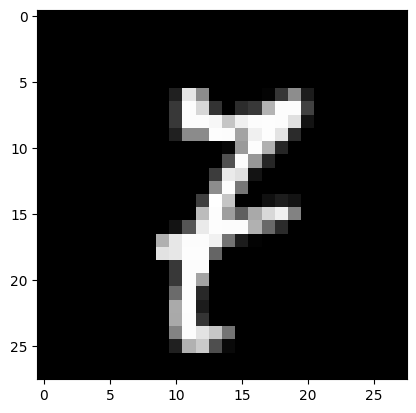

In [91]:
i = np.random.randint(0, 60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [9]:
X_train[0].shape

(28, 28)

In [92]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [93]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [94]:
X_train = (X_train - 127.5) / 127.5

In [14]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [95]:
buffer_size = 60000
batch_size = 256

In [96]:
buffer_size / batch_size # mini-batch- gradiat decent

234.375

In [97]:
type(X_train)

numpy.ndarray

In [98]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

2024-07-11 18:06:11.069509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [99]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [100]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [101]:
7 * 7 * 256

12544

In [102]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=False, activation='tanh'))

  network.summary()

  return network

In [103]:
generator = build_generator()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [104]:
# generator.input

In [105]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 9.9172732e-03, -1.4357275e-02, -1.7364304e-01, -1.5994081e-01,
        -1.0765910e+00,  3.3496588e-01, -2.3493208e-01, -1.3916256e-01,
         9.3939495e-01,  6.2998843e-01,  9.3517041e-01,  6.2420458e-01,
         1.6022600e-01,  1.5524153e-01,  3.0392215e-01, -1.2098643e+00,
        -5.2928865e-01, -6.2308288e-01,  1.1096339e+00, -8.7682658e-01,
        -7.8778946e-01, -6.7405450e-01, -6.4956743e-01,  6.7575991e-01,
         4.6936384e-01,  8.7166536e-01,  3.2427388e-01, -1.2560685e+00,
        -5.9503037e-01,  5.9788400e-01, -1.5652182e+00,  1.9948651e-01,
         6.7541391e-01,  4.2088068e-01,  2.4213576e+00, -1.2814547e-01,
        -1.1600479e-01,  4.3336594e-01,  5.2134465e-02, -1.4009117e+00,
         1.8962756e+00, -4.9275905e-01,  1.6200362e+00,  2.6118267e-01,
        -1.7314245e-01, -1.0655113e+00,  1.5559375e+00, -9.1563761e-01,
         1.2564411e+00,  1.4439285e-01,  2.2471952e+00,  2.0033794e-02,
         6.444

In [106]:
generated_image = generator(noise, training = False)

In [107]:
generated_image.shape

TensorShape([1, 28, 28, 1])

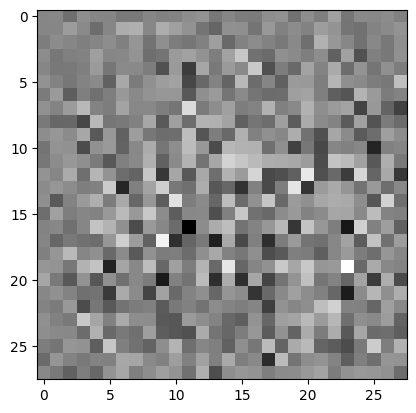

In [108]:
plt.imshow(generated_image[0, :,:,0], cmap='gray');

# Building the discriminator

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [109]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [110]:
7 * 7 * 128

6272

In [111]:
discriminator = build_discriminator()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# discriminator.input

In [114]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00050957]], dtype=float32)>

In [115]:
tf.sigmoid(-0.00249046)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4993774>

# Error calculation

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

This method quantifies how well the discriminator is able to distinguish real images from fakes images. It compares the discriminator predictions on real images with an array of 1s and the discriminator predictions on fake (generated) images with an array of 0s.

In [116]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [117]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [118]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [119]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [120]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Training the GAN and visualizing the results

- Based on: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.


In [121]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [122]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [123]:
batch_size, noise_dimension

(256, 100)

In [43]:
# @tf.function
# def train(images):
#   noise = tf.random.normal([batch_size, noise_dimension])
#   #print(noise.shape)
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     generated_images = generator(noise, training = True)

#     expected_output = discriminator(images, training = True)
#     fake_output = discriminator(generated_images, training = True)

#     gen_loss = generator_loss(fake_output)
#     disc_loss = discriminator_loss(expected_output, fake_output)

#   generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#   generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [44]:
# tf.config.run_functions_eagerly(True)
# X_train_batch = X_train.as_numpy_iterator().next()
# train(X_train_batch)

In [45]:
# test_images = tf.random.normal([number_of_images, noise_dimension])
# test_images.shape

TensorShape([16, 100])

In [46]:
60000 / 256

234.375

In [47]:
# def train_gan(dataset, epochs, test_images):
#   for epoch in range(epochs):
#     #print(epoch)
#     for image_batch in dataset:
#       #print(image_batch.shape)
#       train(image_batch)

#     print('Epoch: ', epoch + 1)
#     generated_images = generator(test_images, training = False)
#     fig = plt.figure(figsize = (10,10))
#     for i in range(generated_images.shape[0]):
#       plt.subplot(4,4,i + 1)
#       plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#       plt.axis('off')
#     plt.show()

Epoch:  1


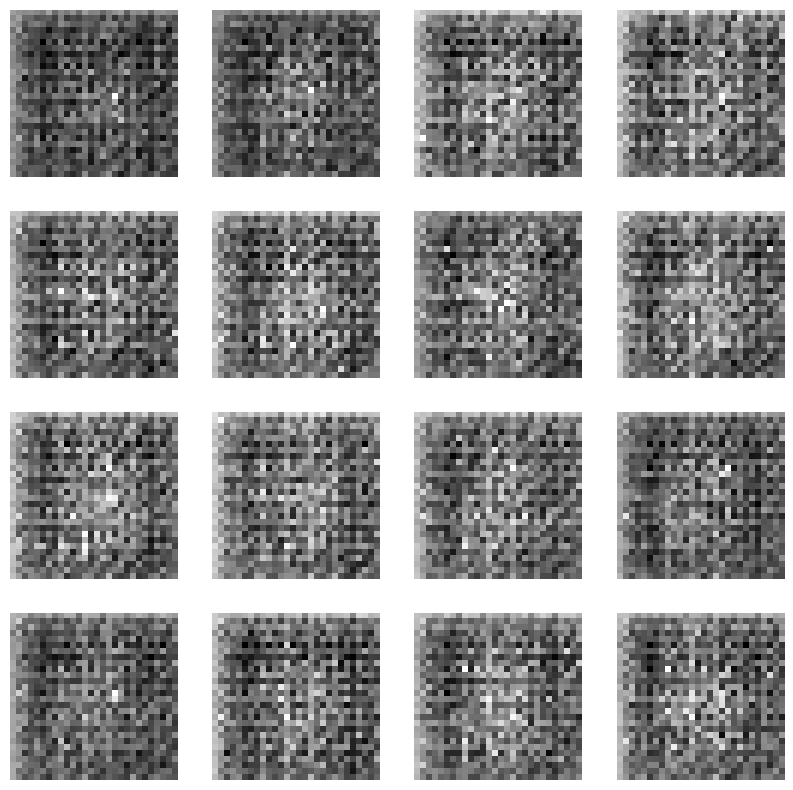

Epoch:  2


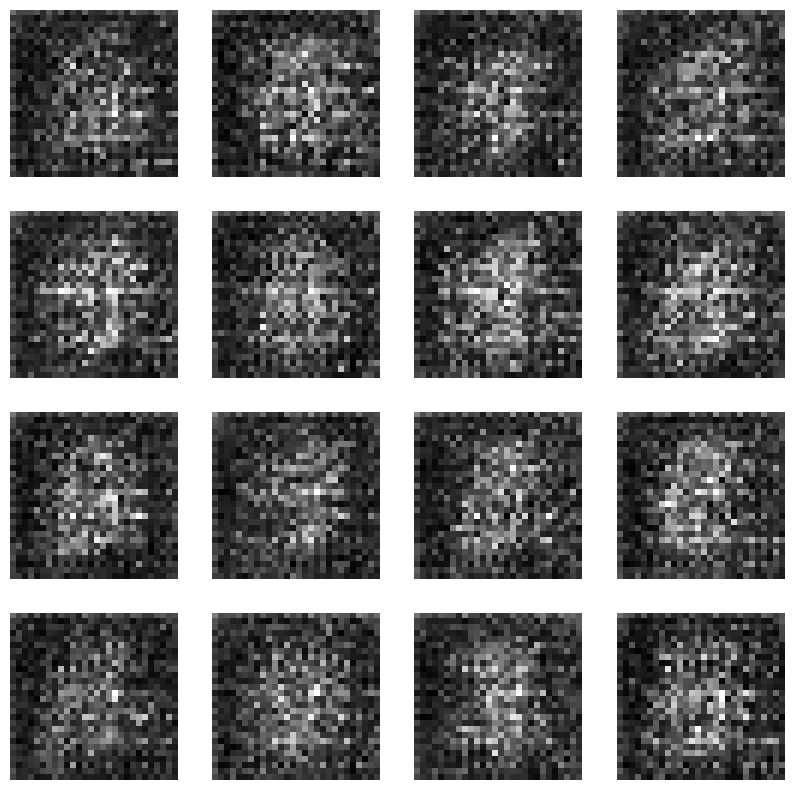

Epoch:  3


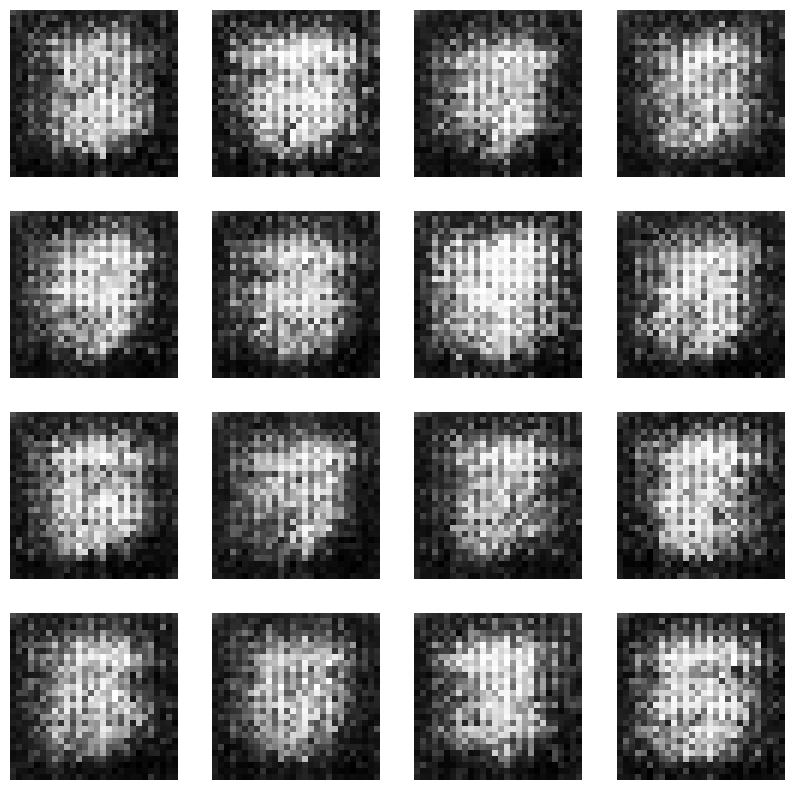

Epoch:  4


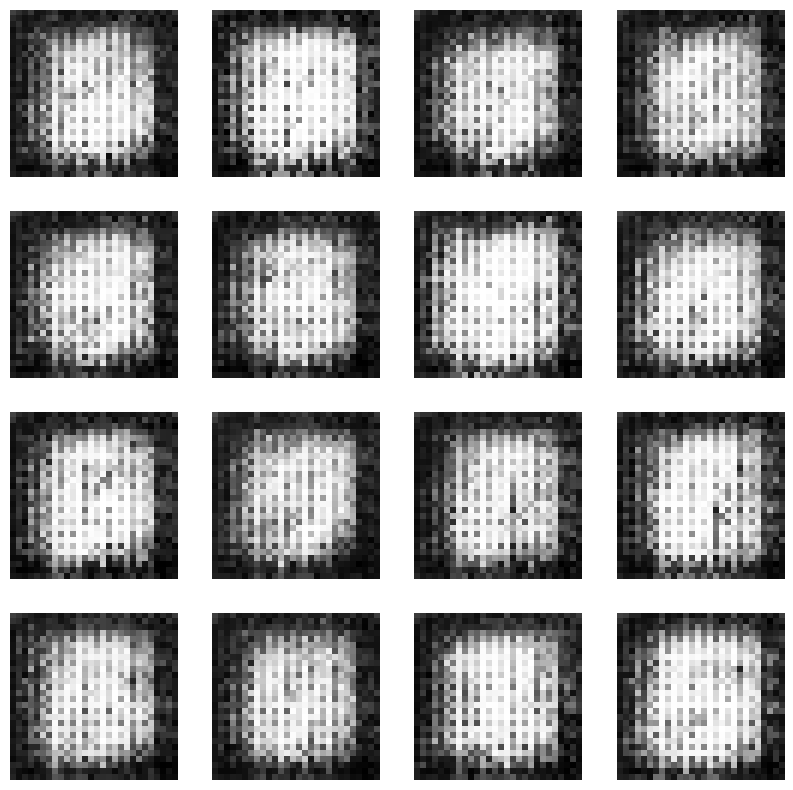

Epoch:  5


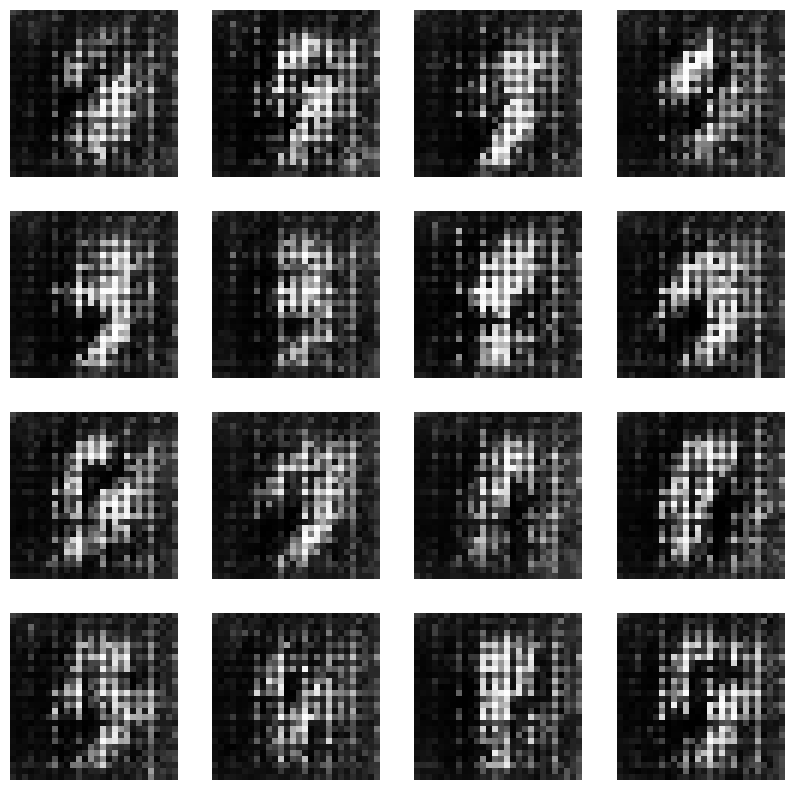

Epoch:  6


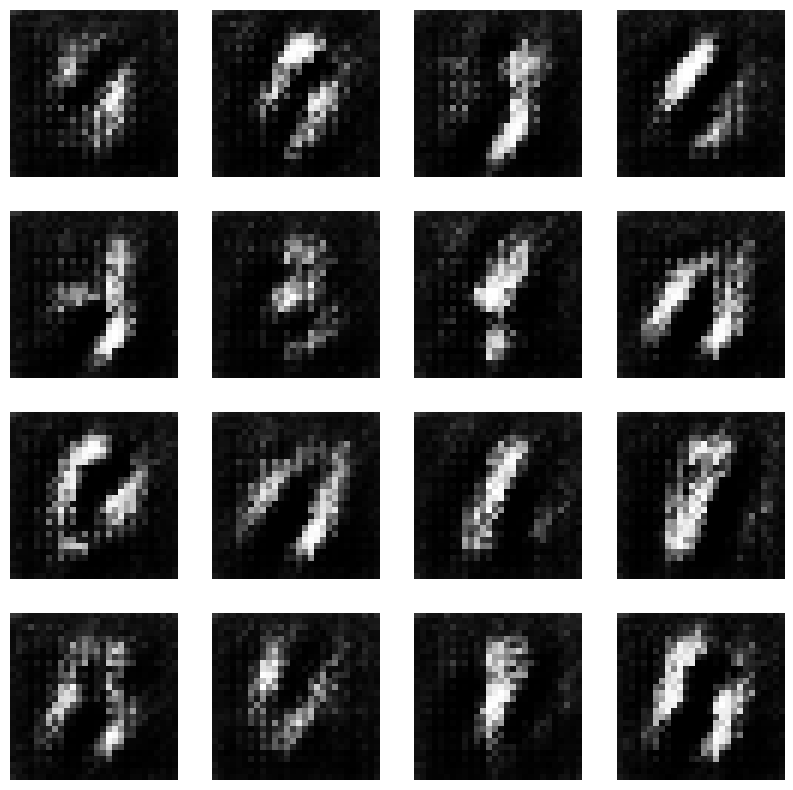

Epoch:  7


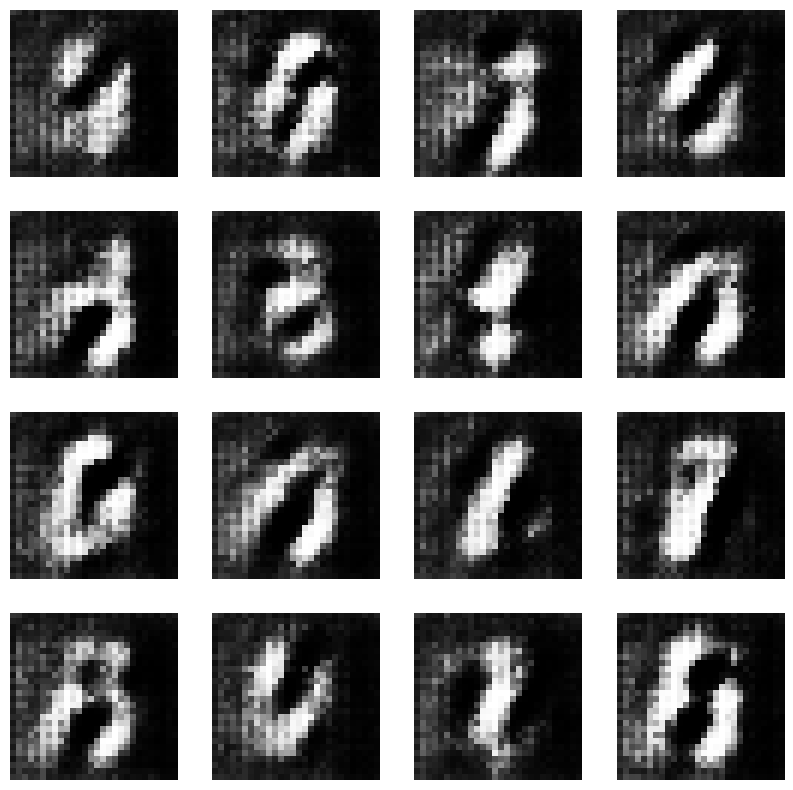

Epoch:  8


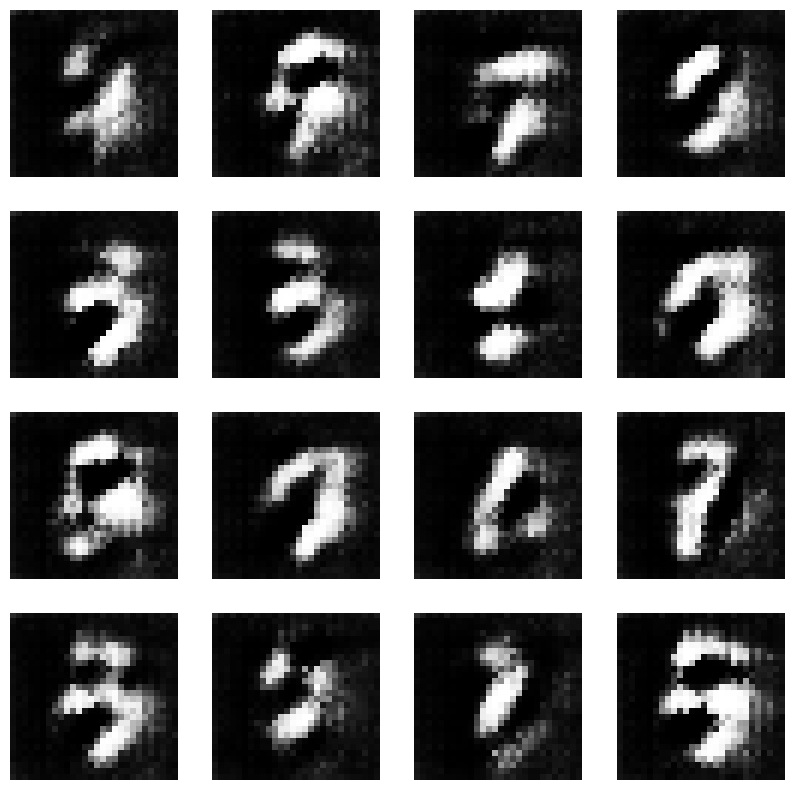

Epoch:  9


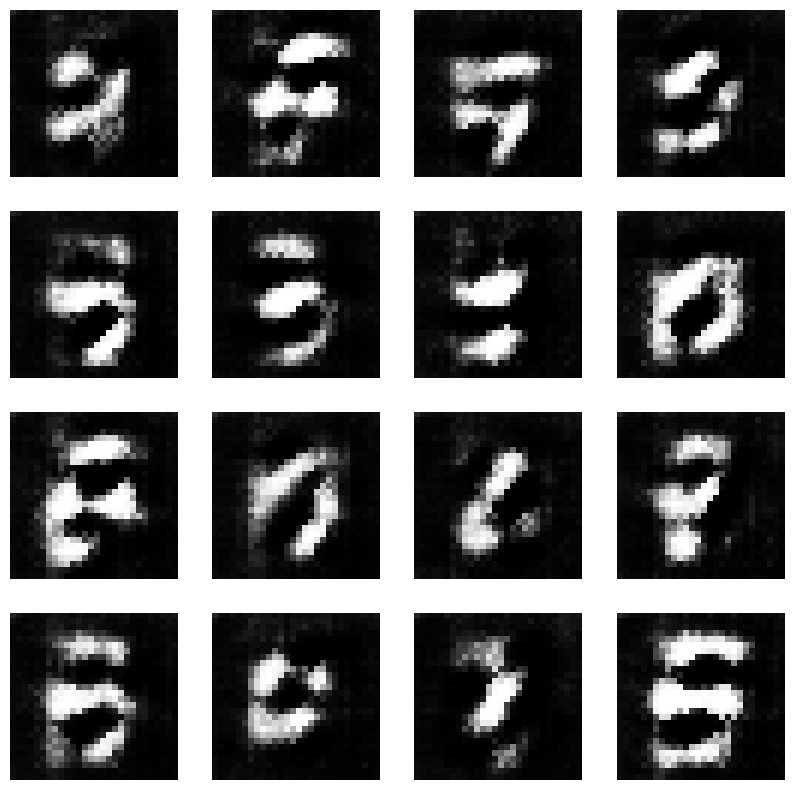

Epoch:  10


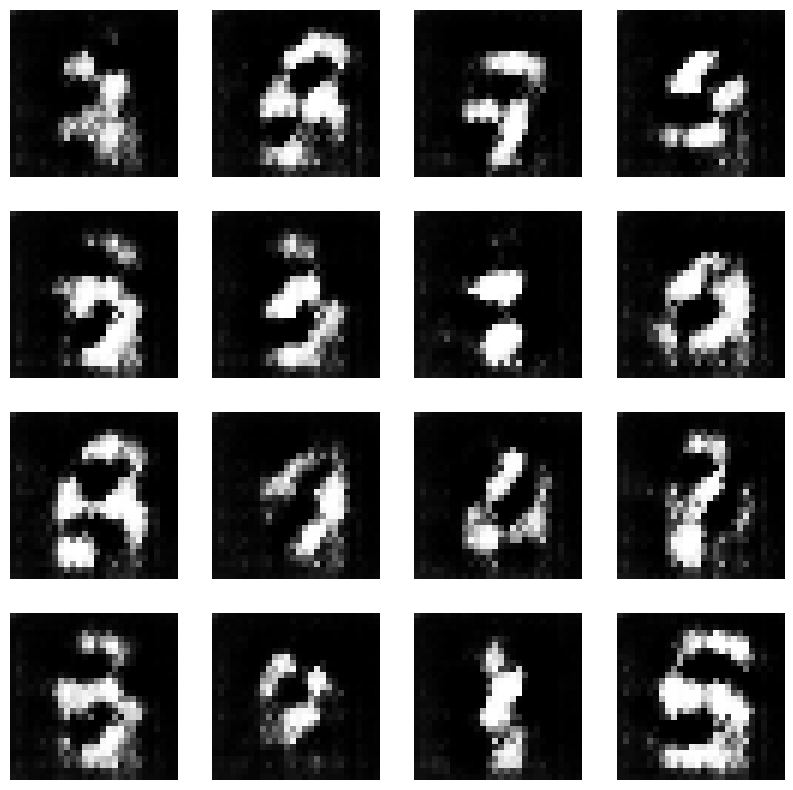

Epoch:  11


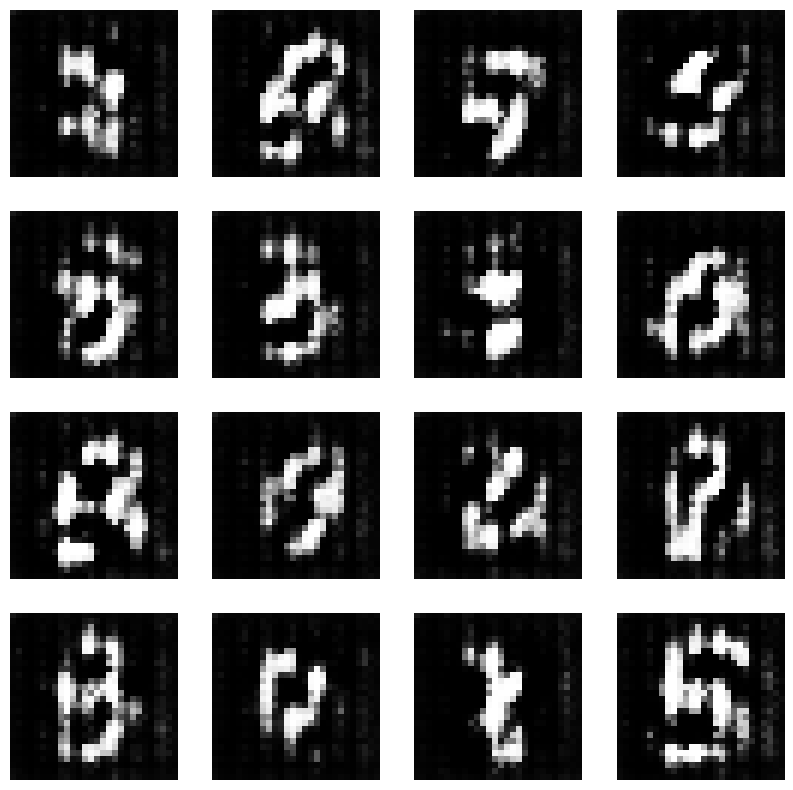

Epoch:  12


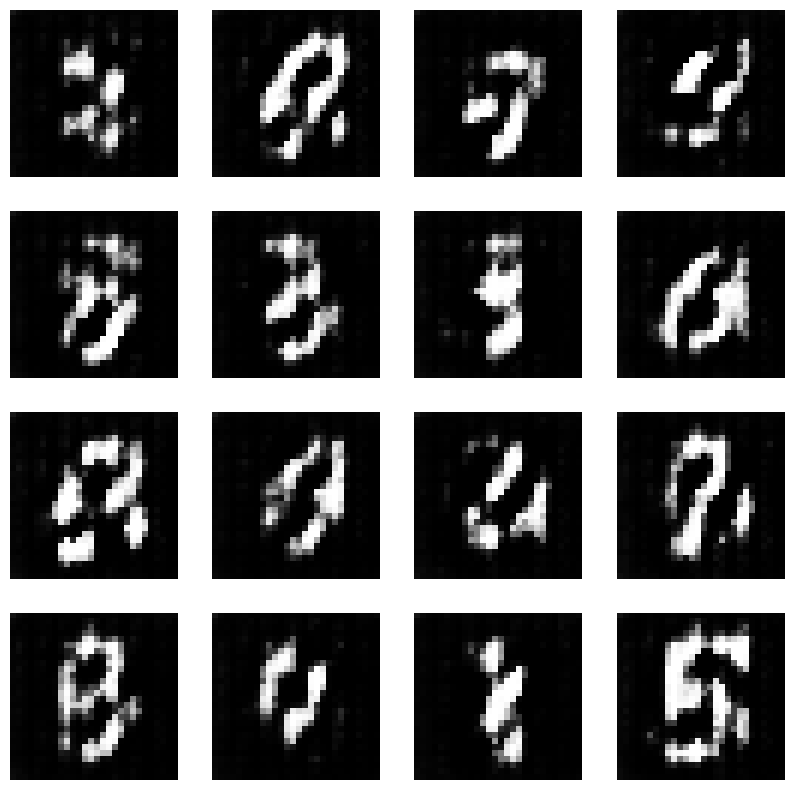

Epoch:  13


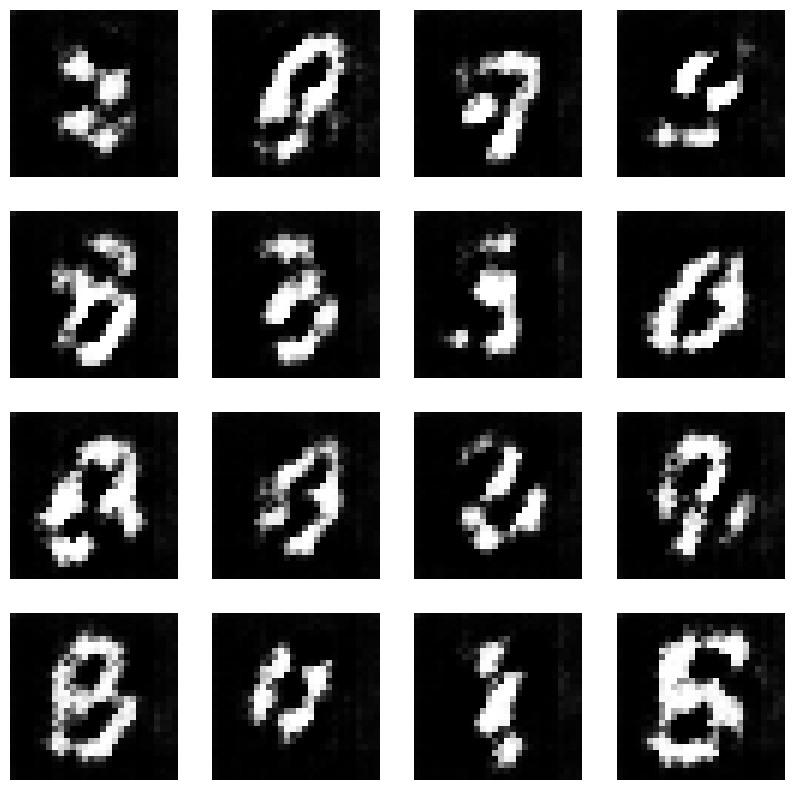

Epoch:  14


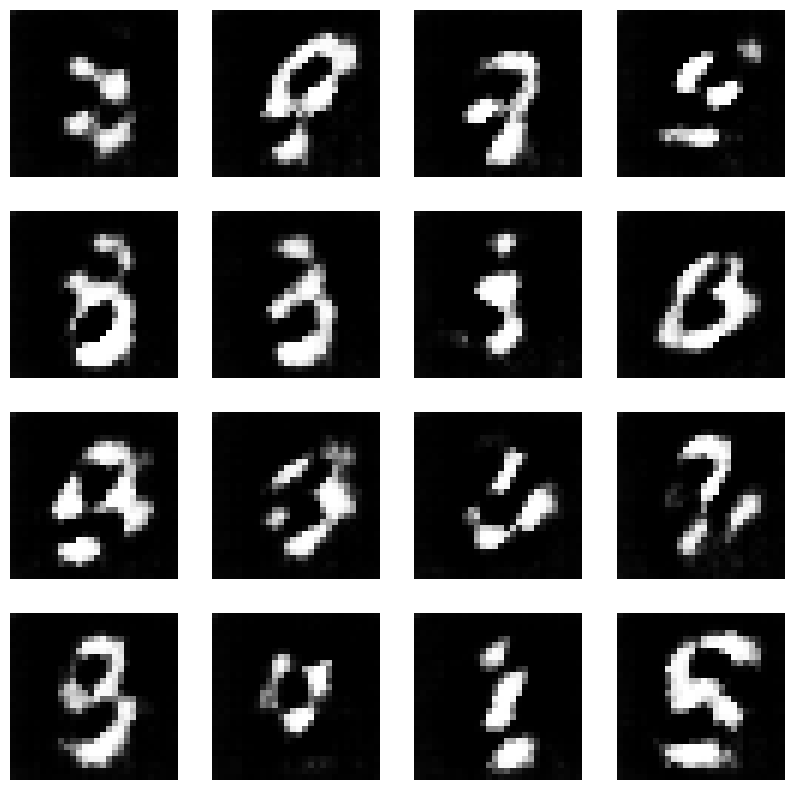

Epoch:  15


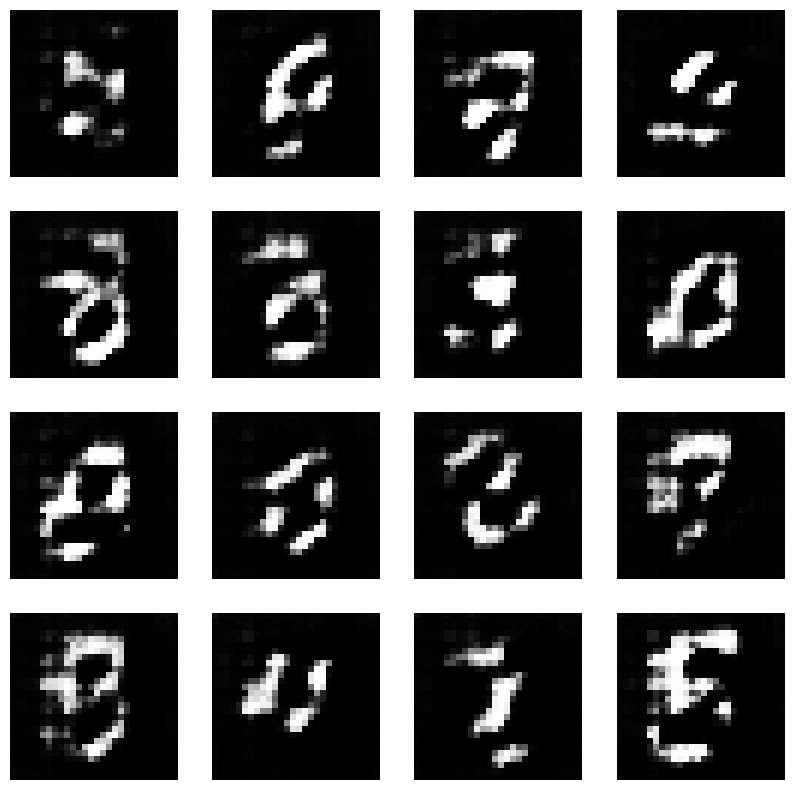

Epoch:  16


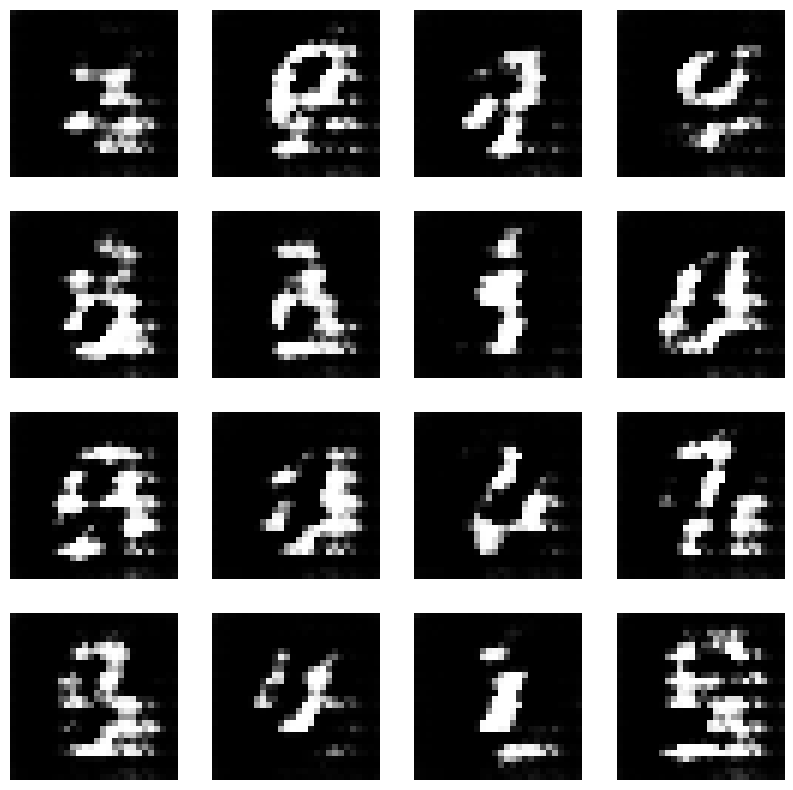

Epoch:  17


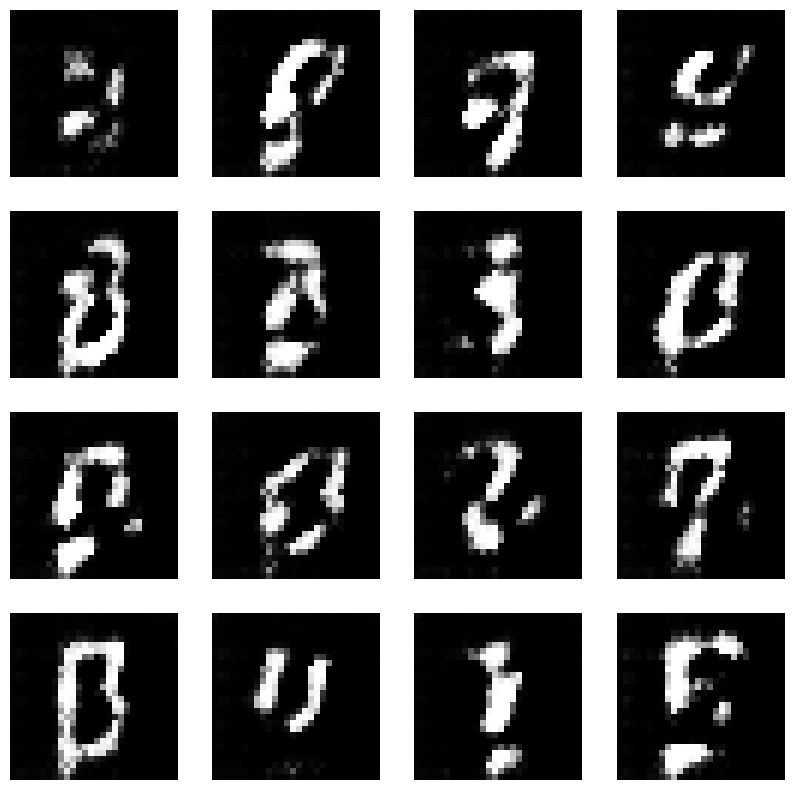

Epoch:  18


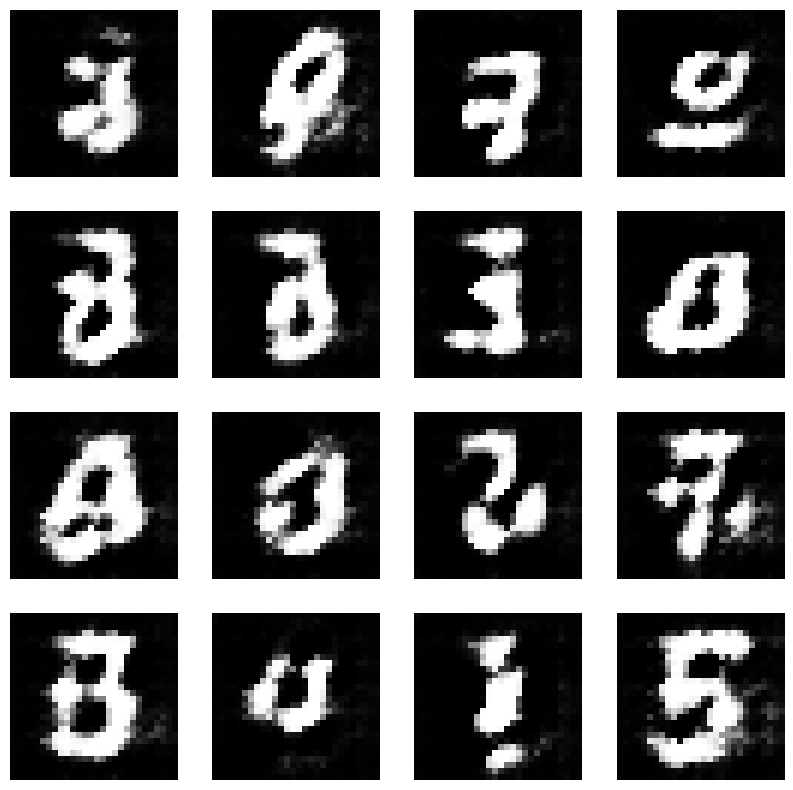

Epoch:  19


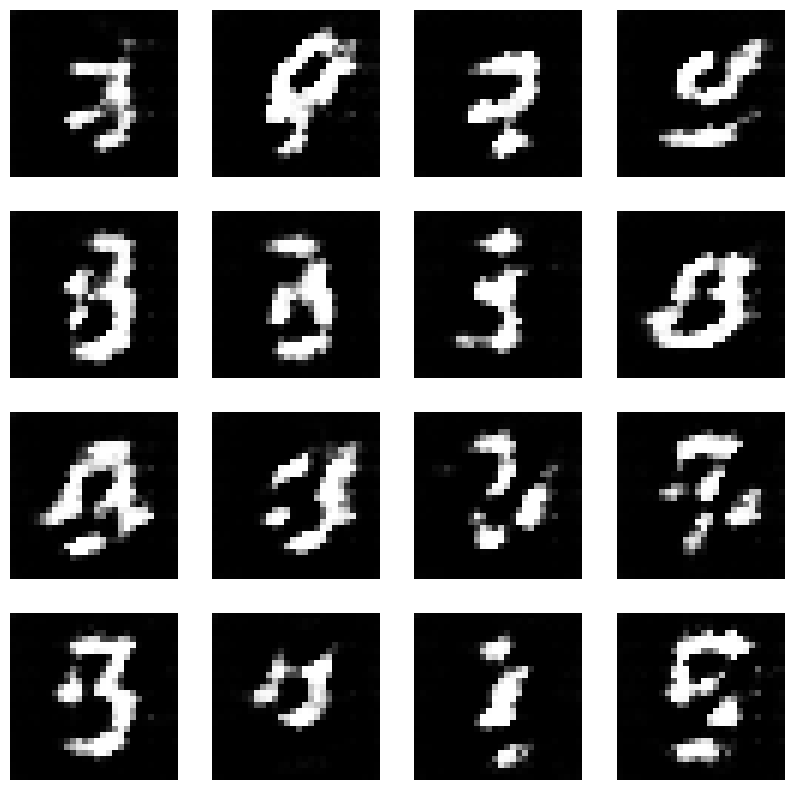

Epoch:  20


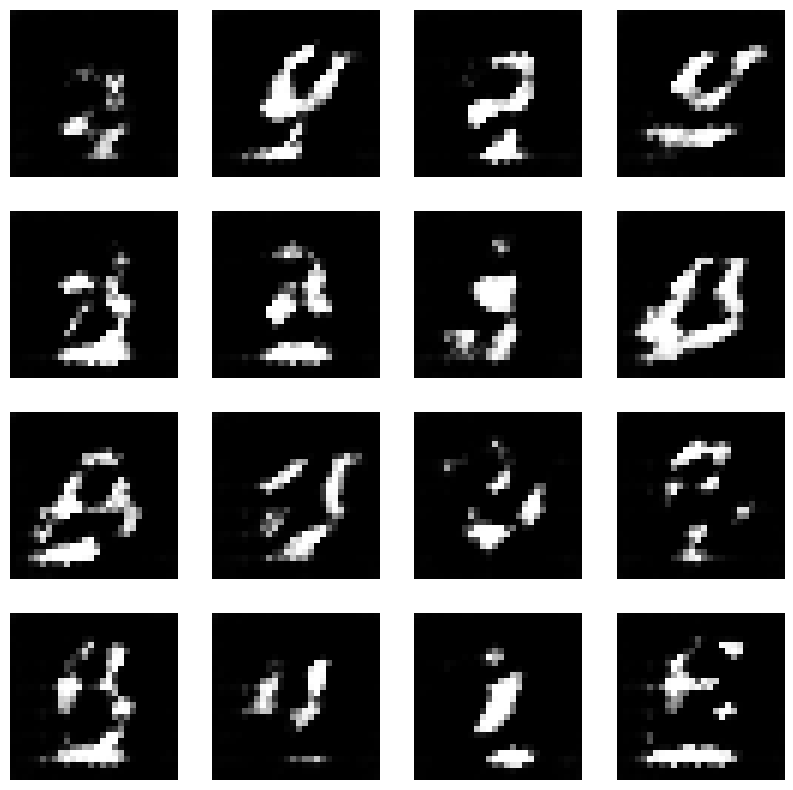

Epoch:  21


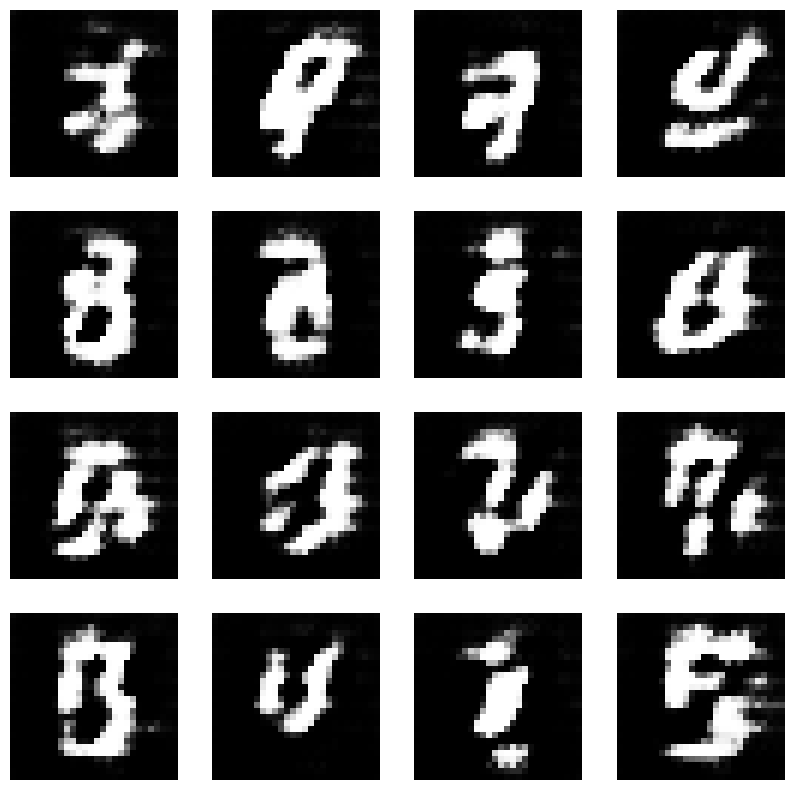

Epoch:  22


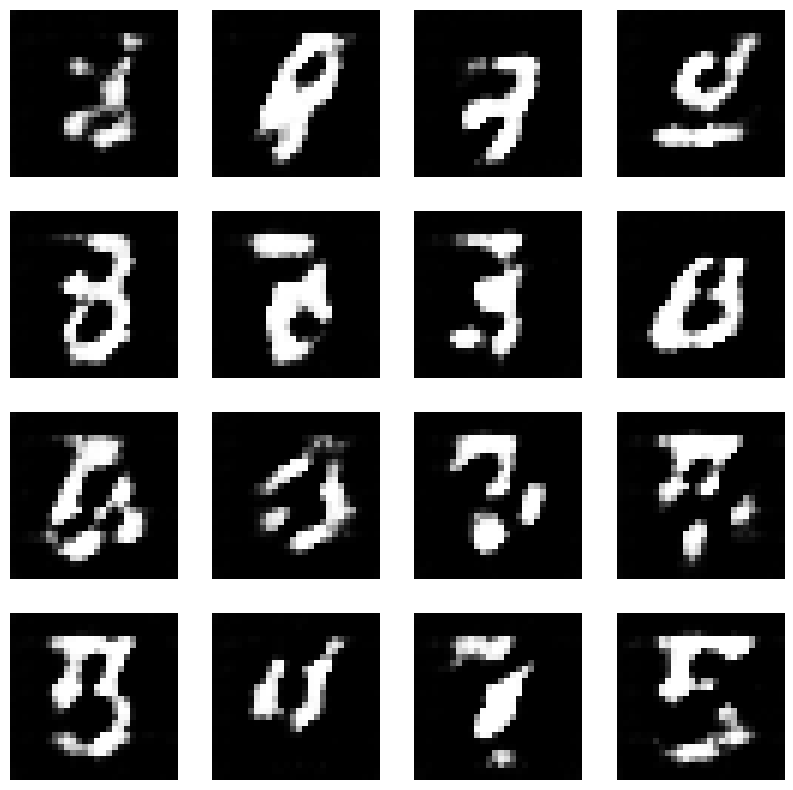

Epoch:  23


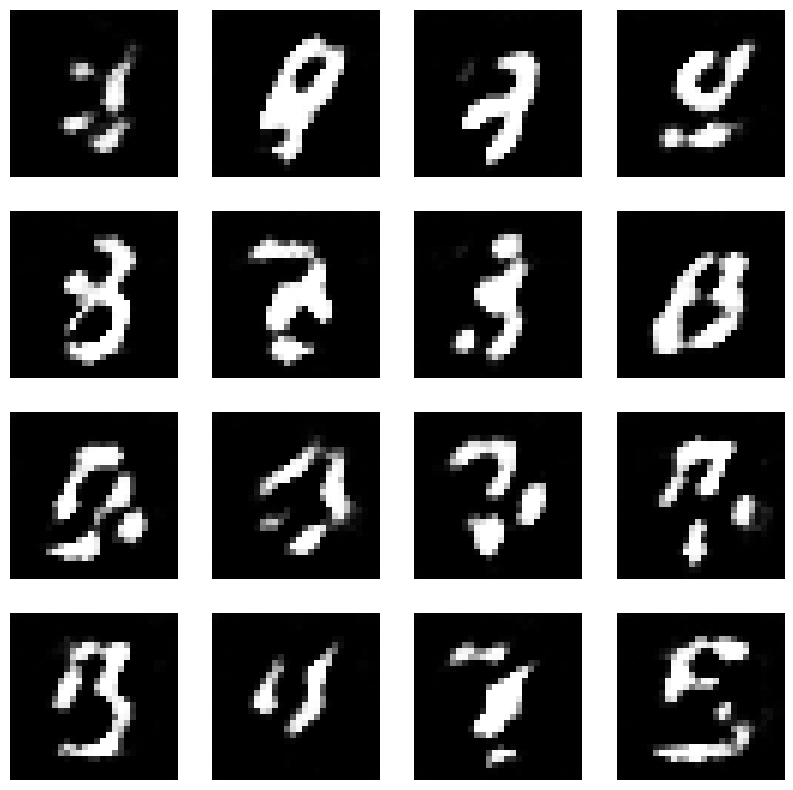

Epoch:  24


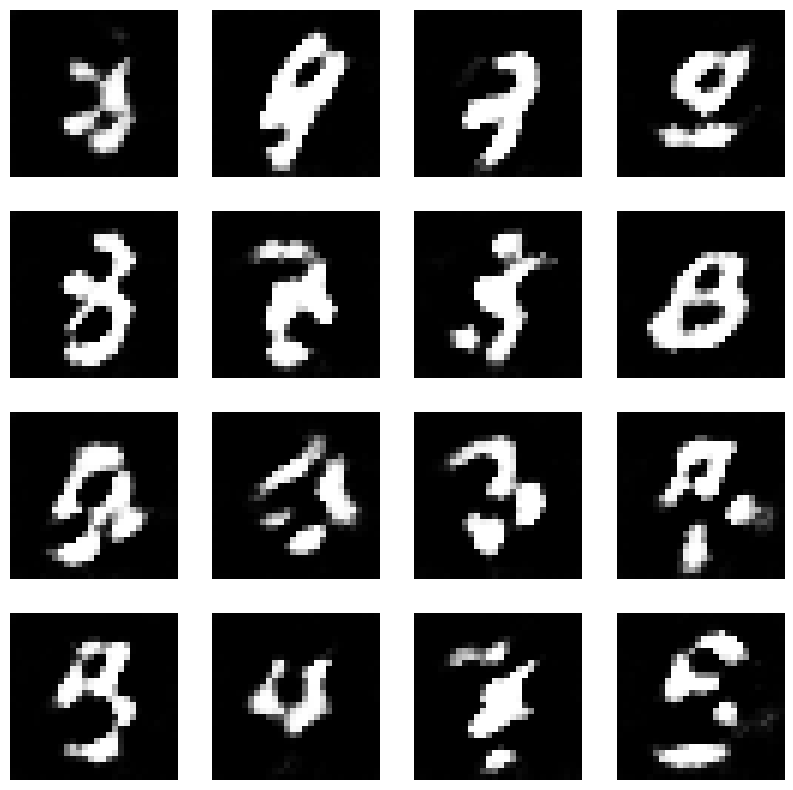

Epoch:  25


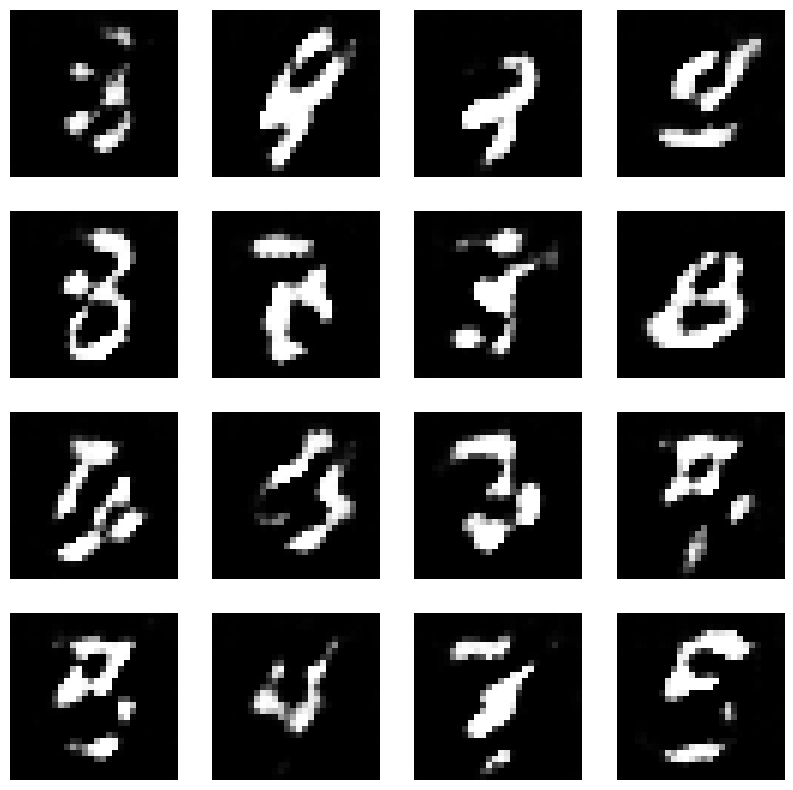

Epoch:  26


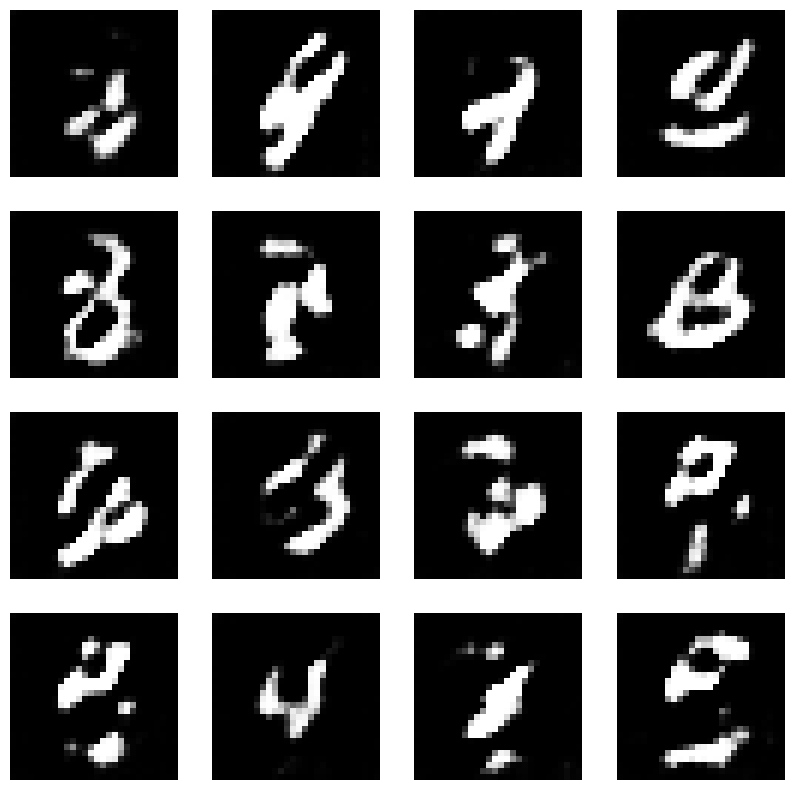

Epoch:  27


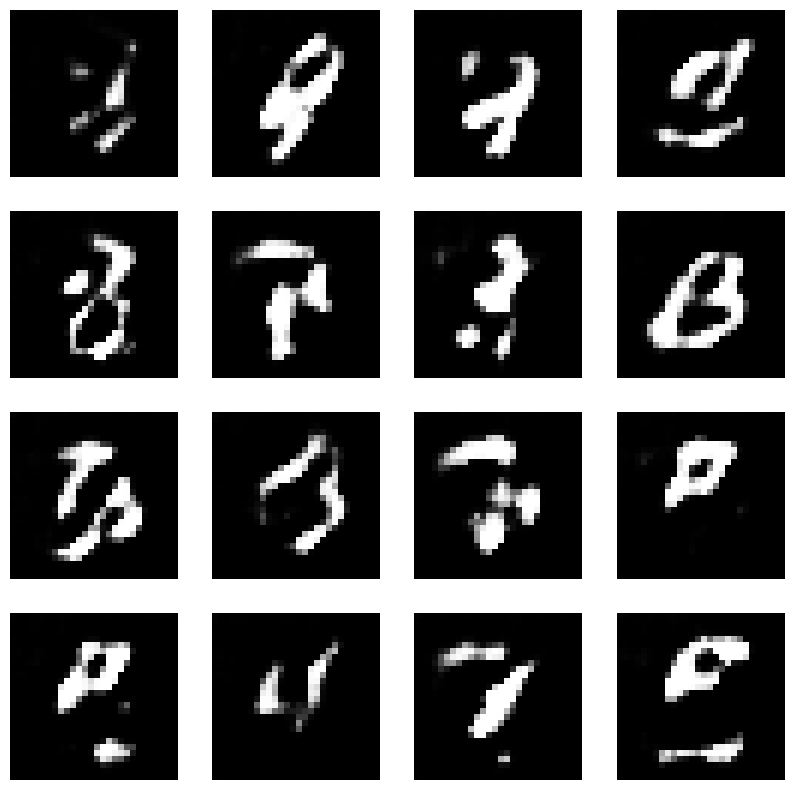

Epoch:  28


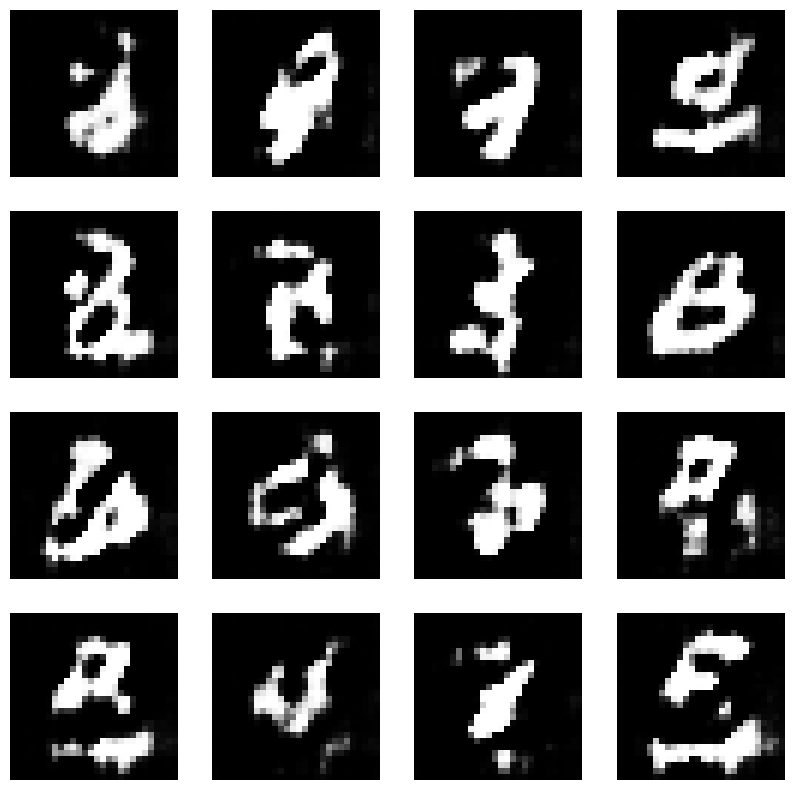

Epoch:  29


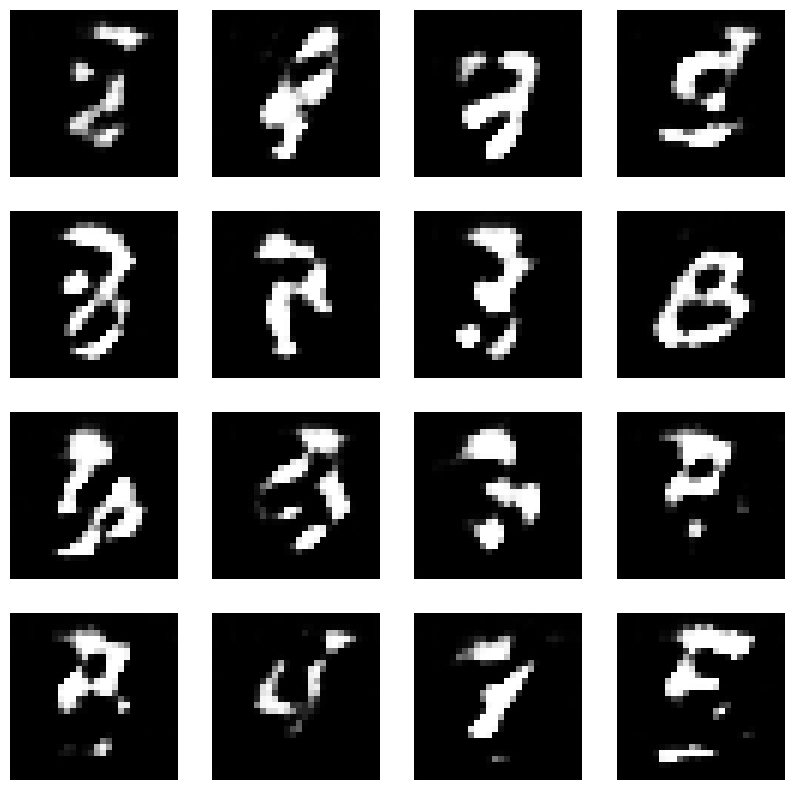

Epoch:  30


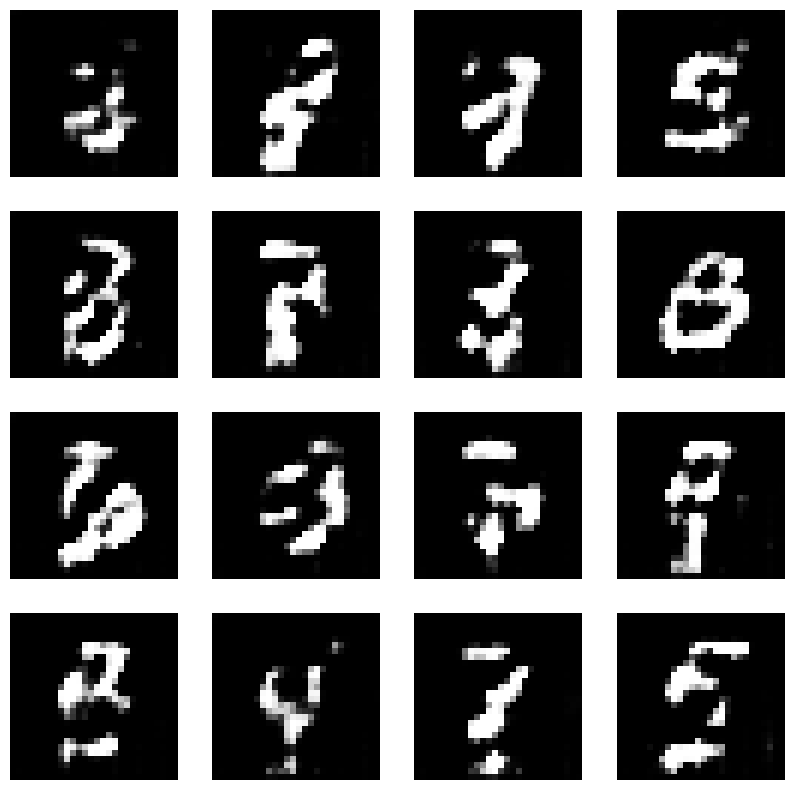

Epoch:  31


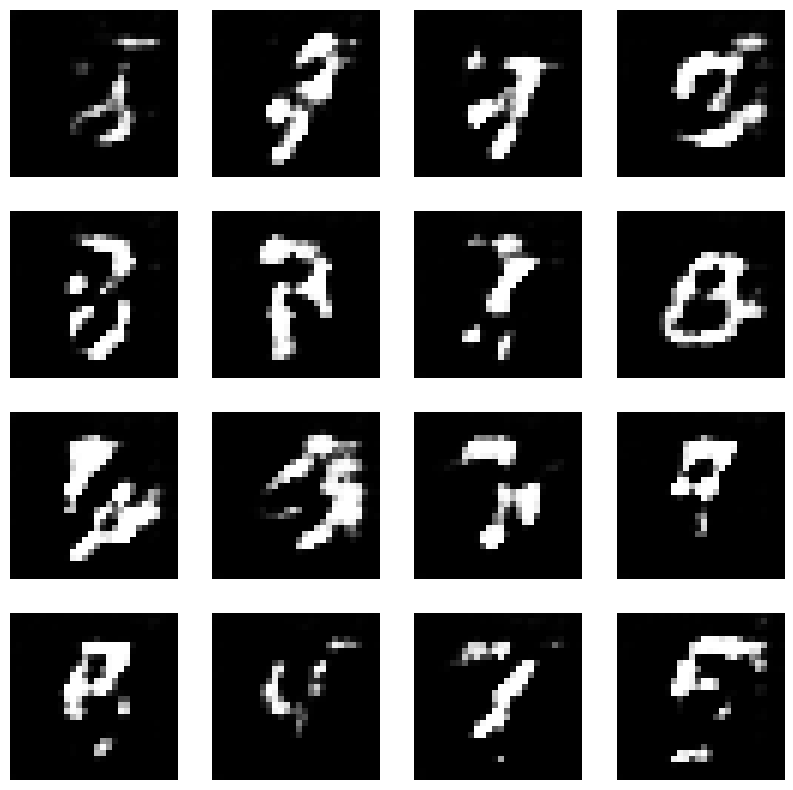

Epoch:  32


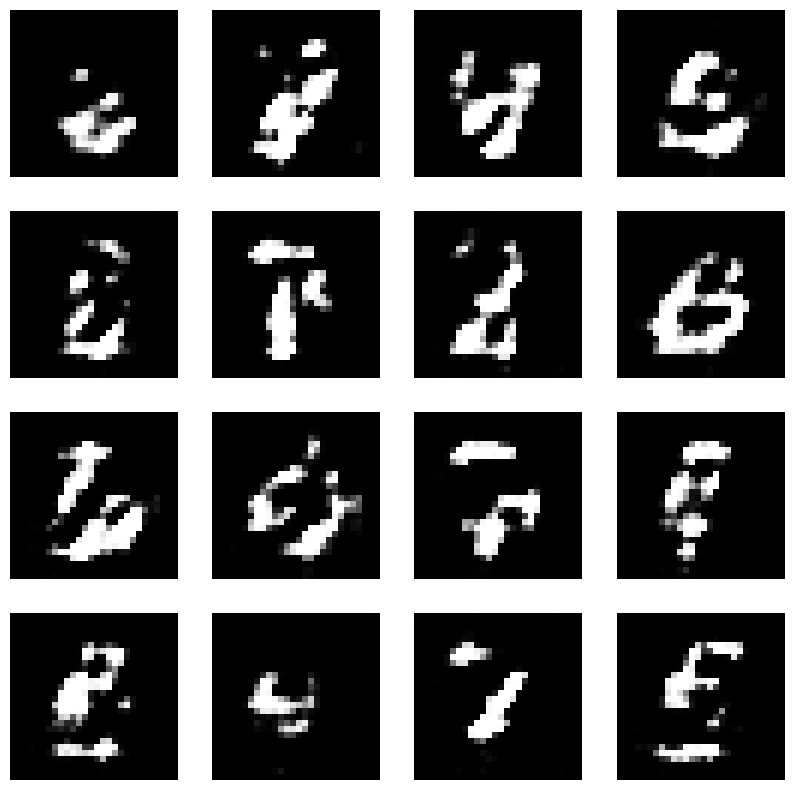

Epoch:  33


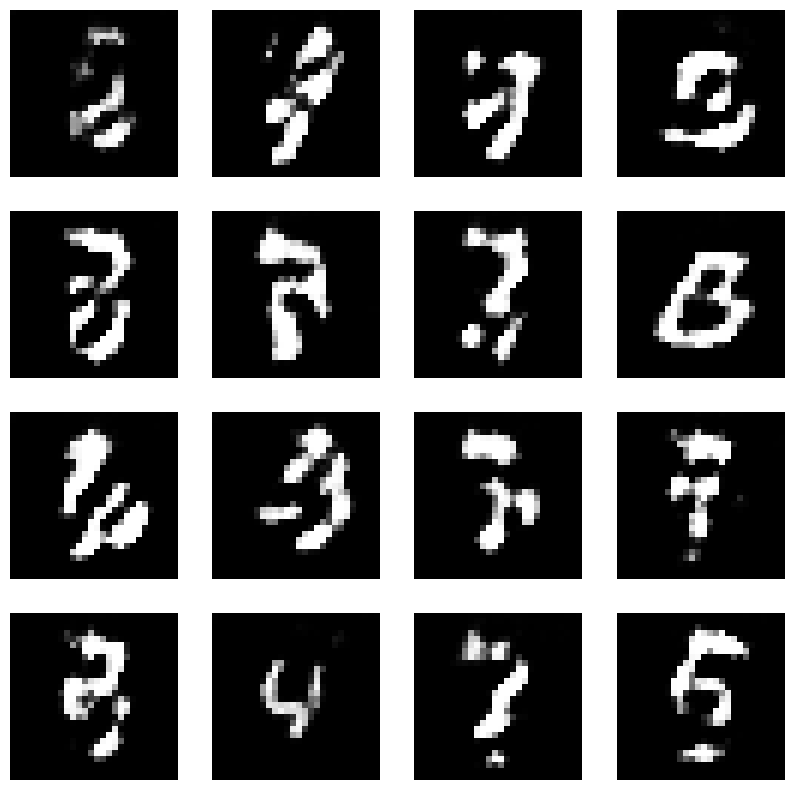

Epoch:  34


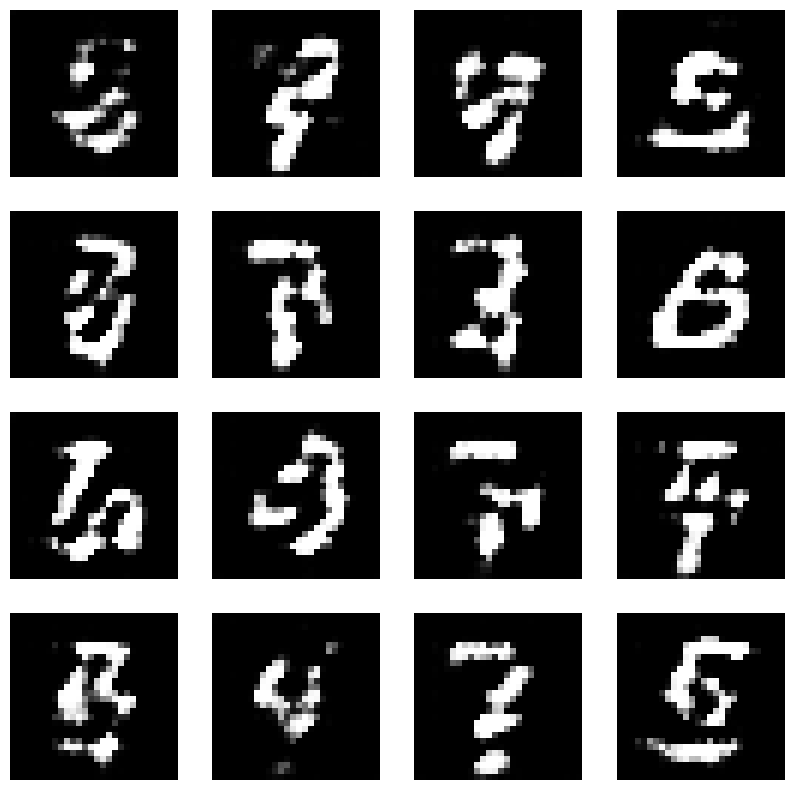

Epoch:  35


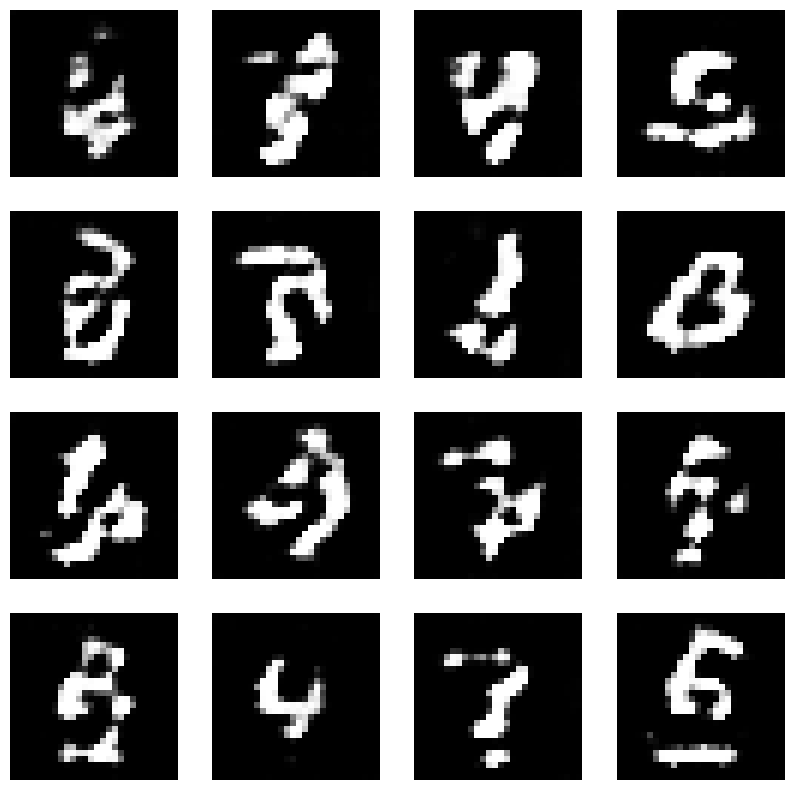

Epoch:  36


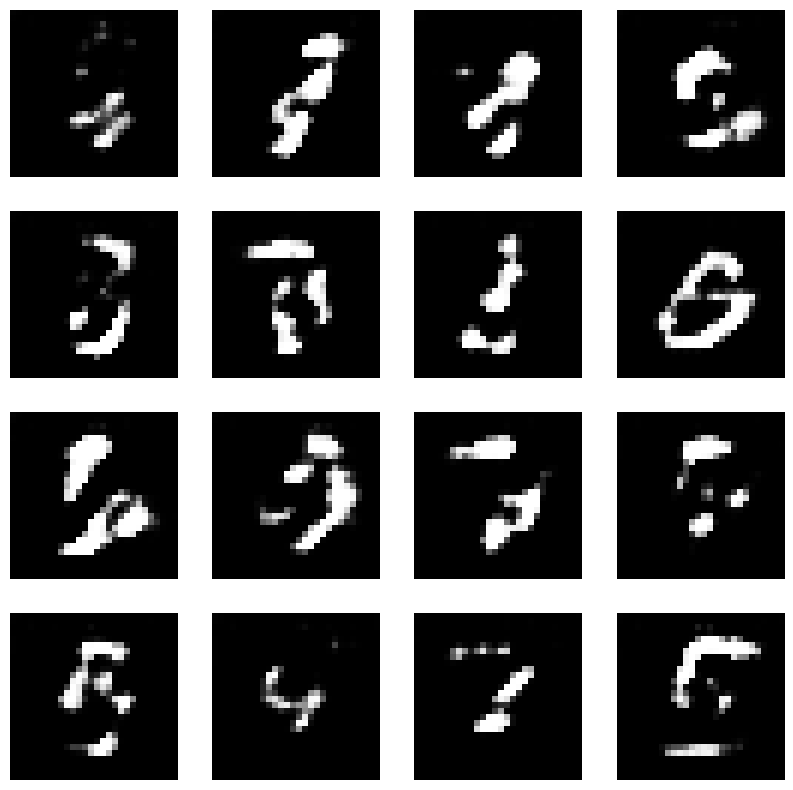

Epoch:  37


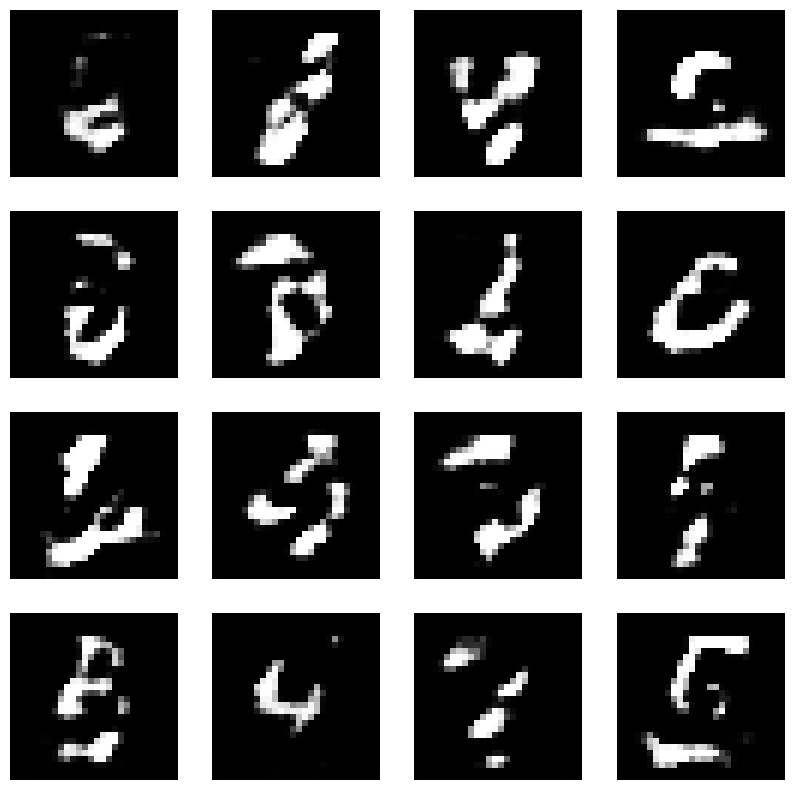

Epoch:  38


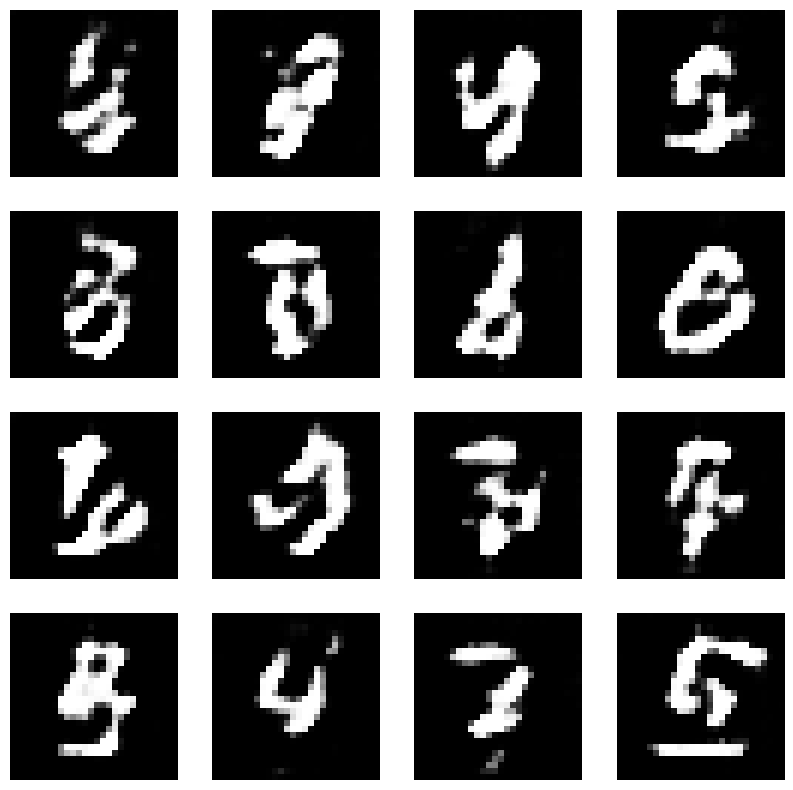

Epoch:  39


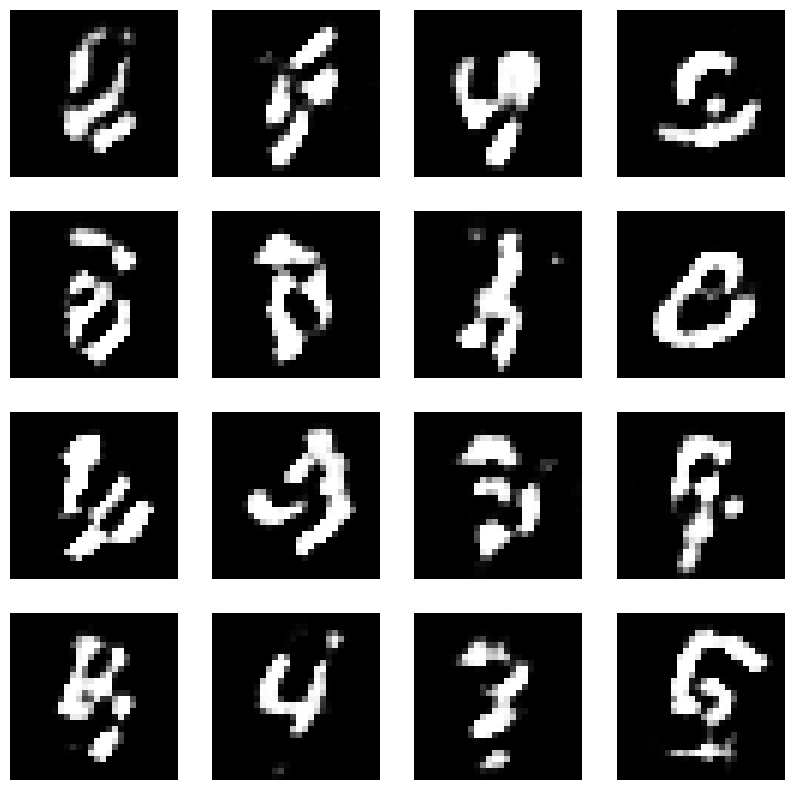

Epoch:  40


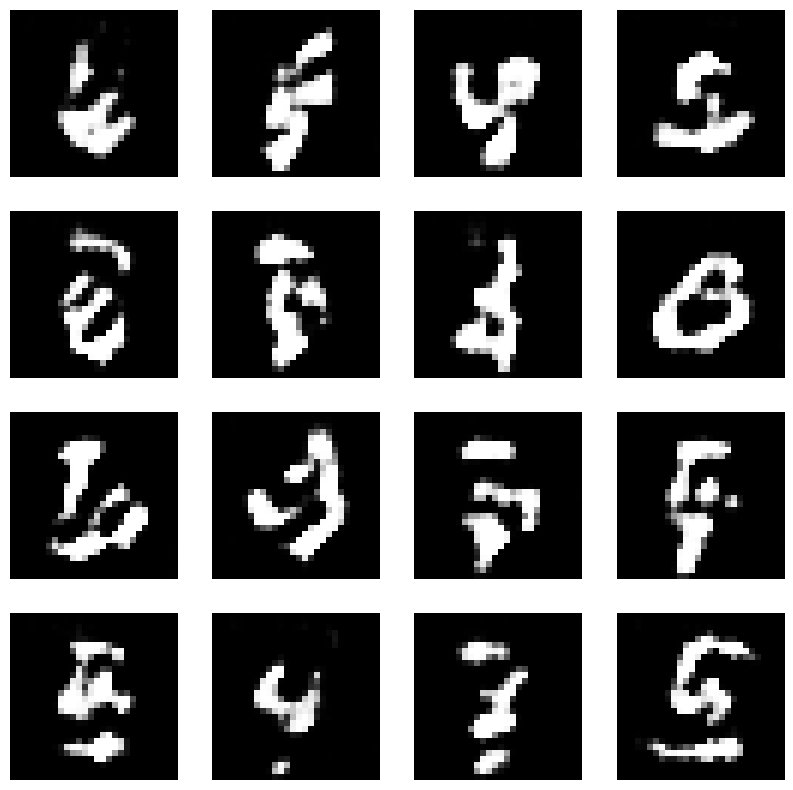

Epoch:  41


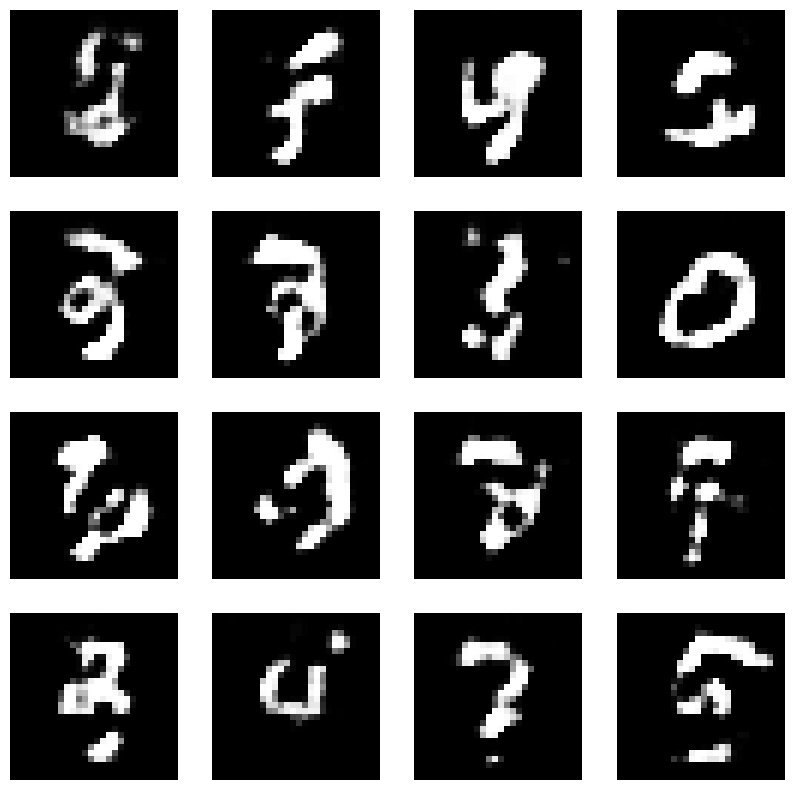

Epoch:  42


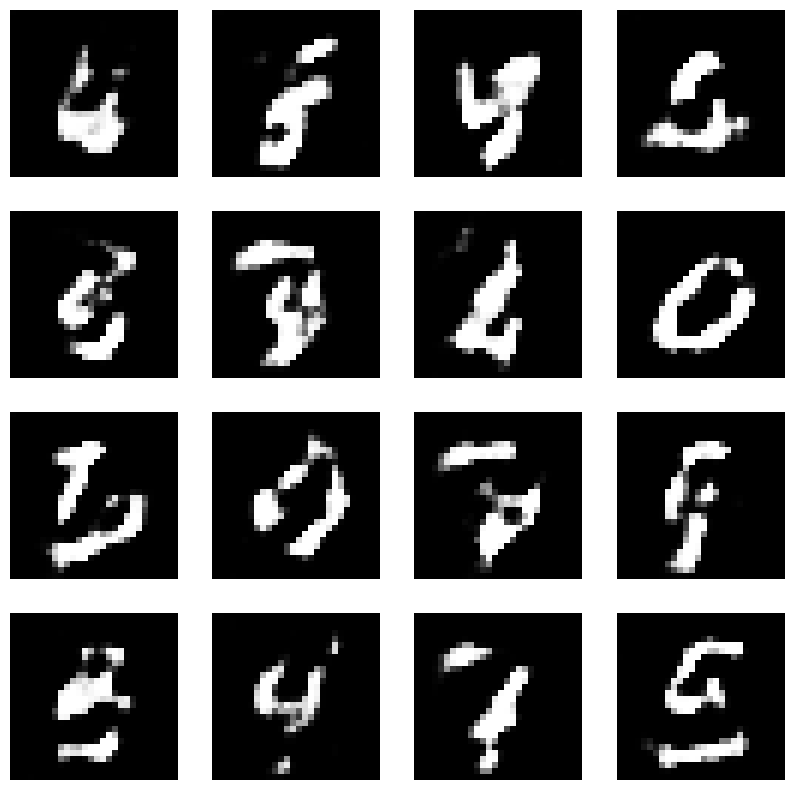

Epoch:  43


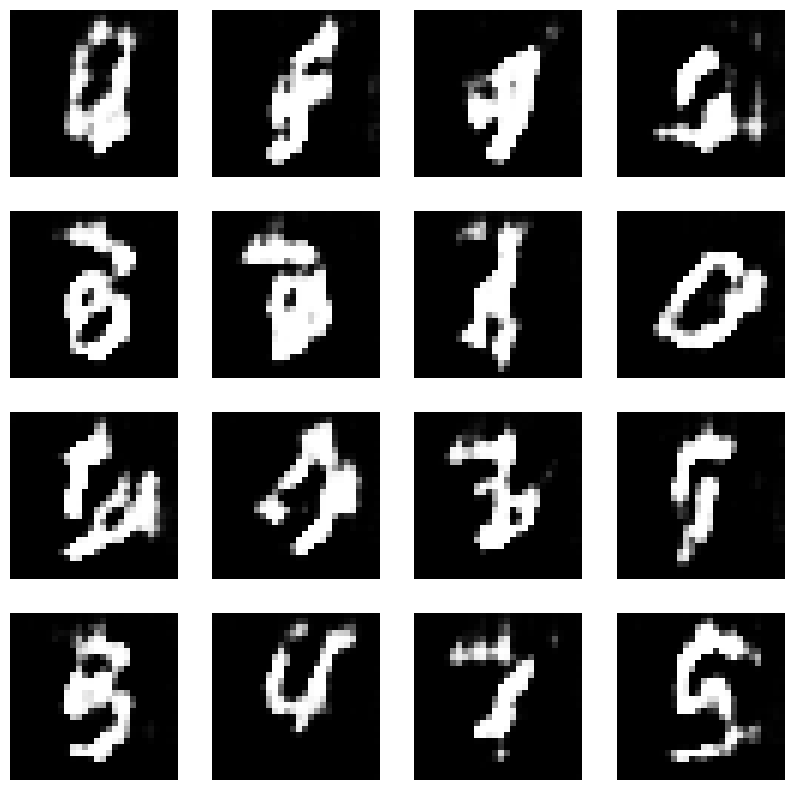

Epoch:  44


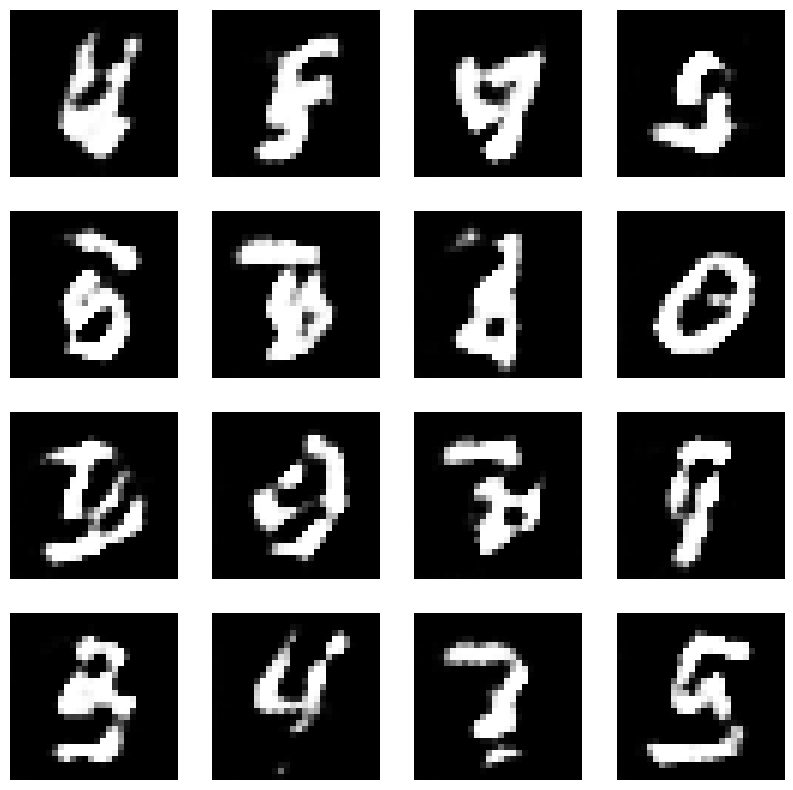

Epoch:  45


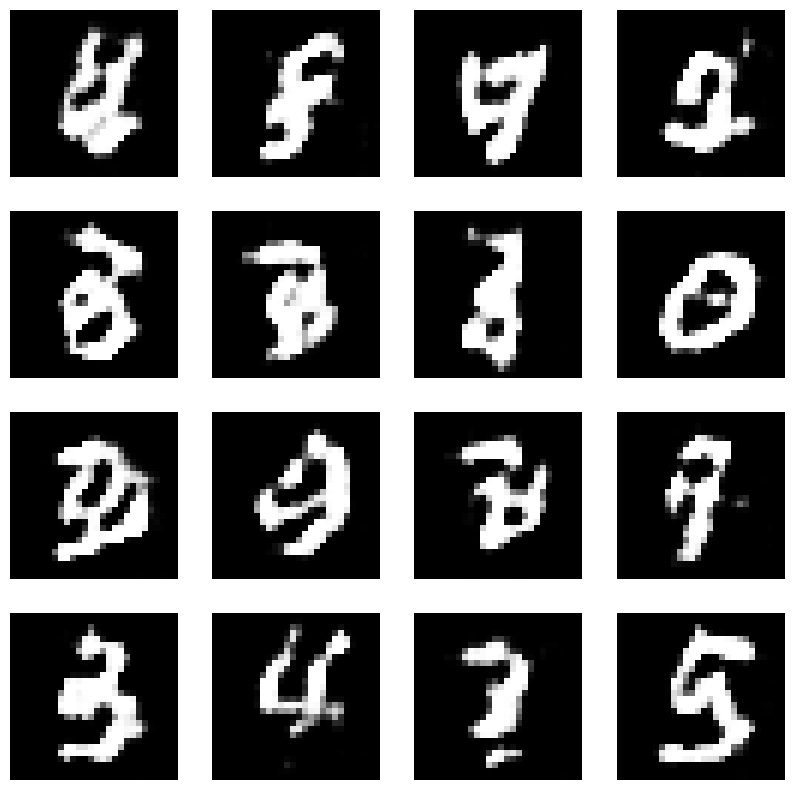

Epoch:  46


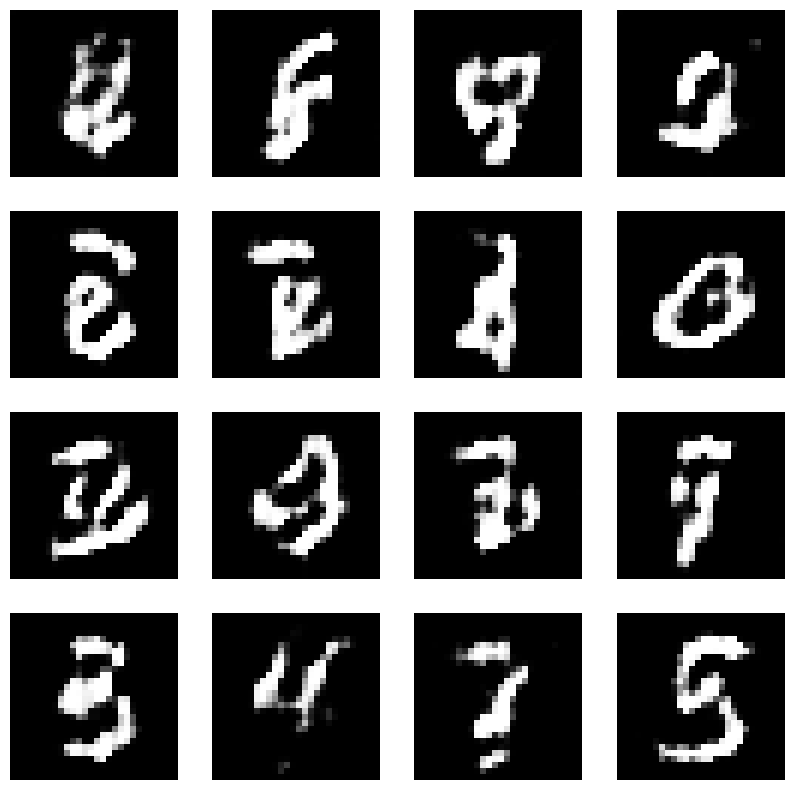

Epoch:  47


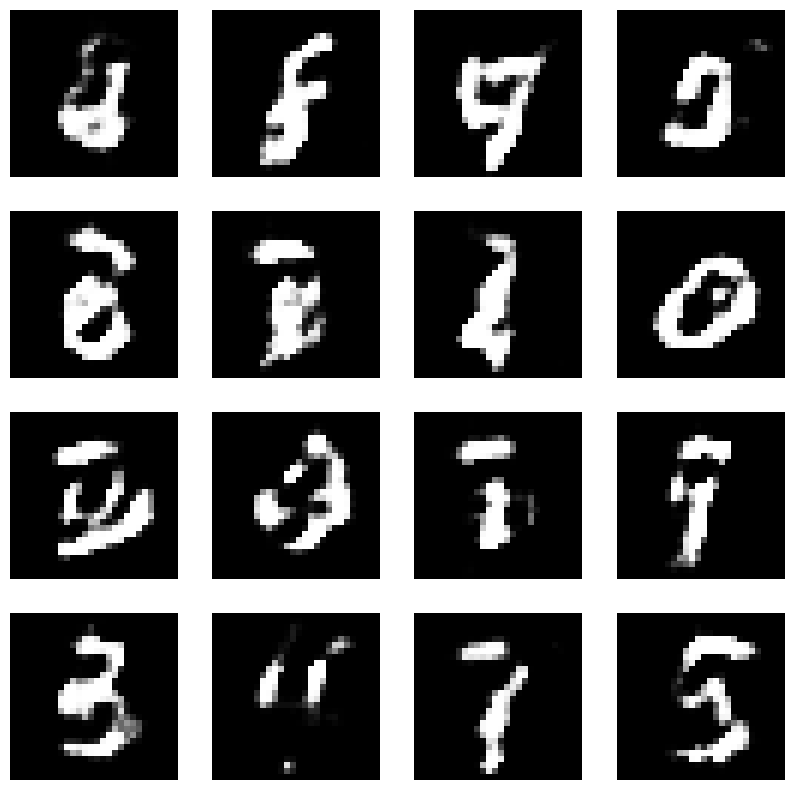

Epoch:  48


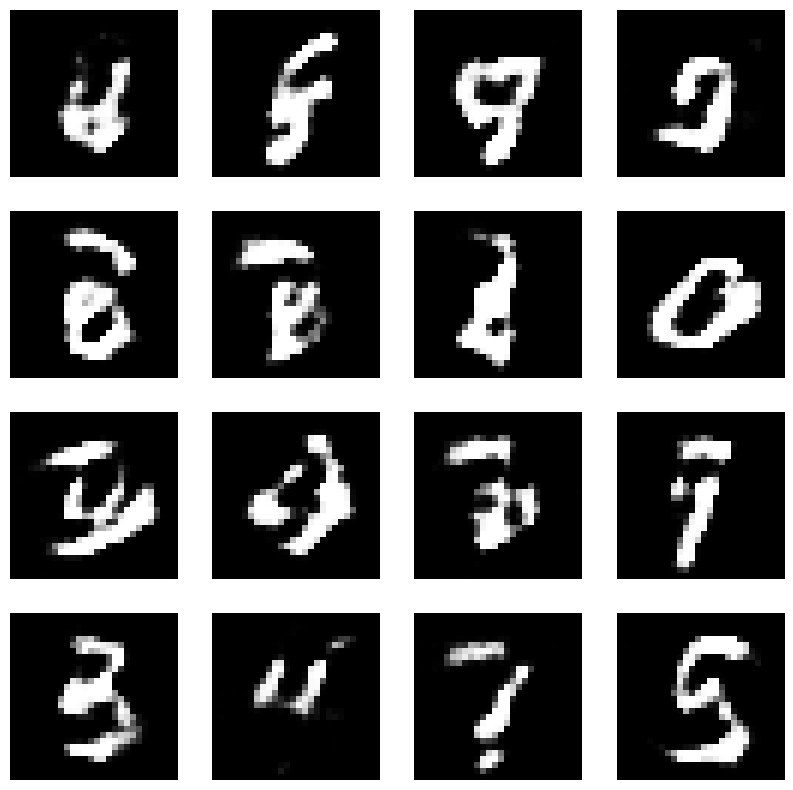

Epoch:  49


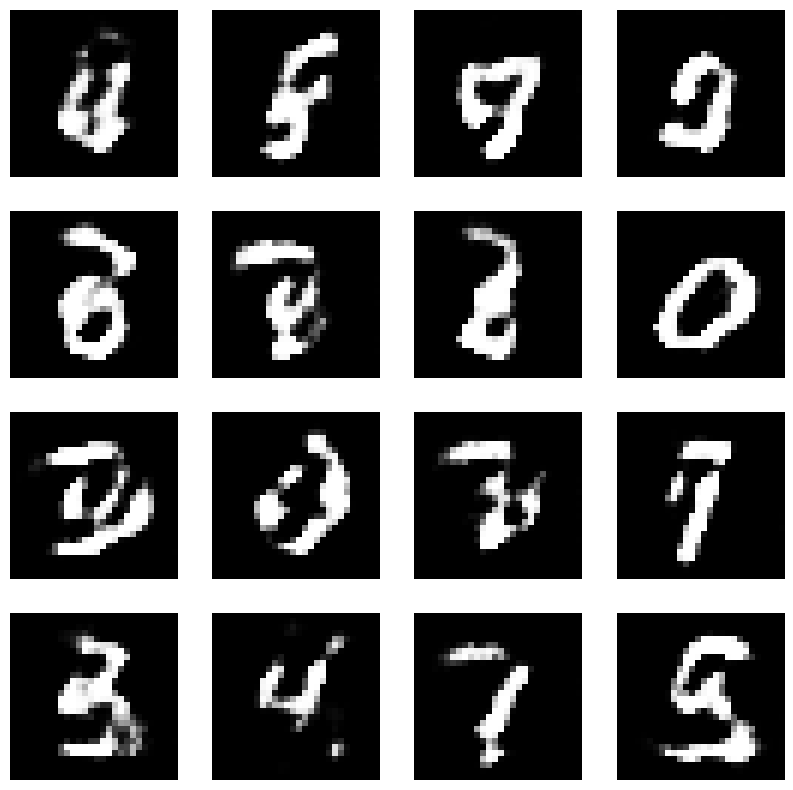

Epoch:  50


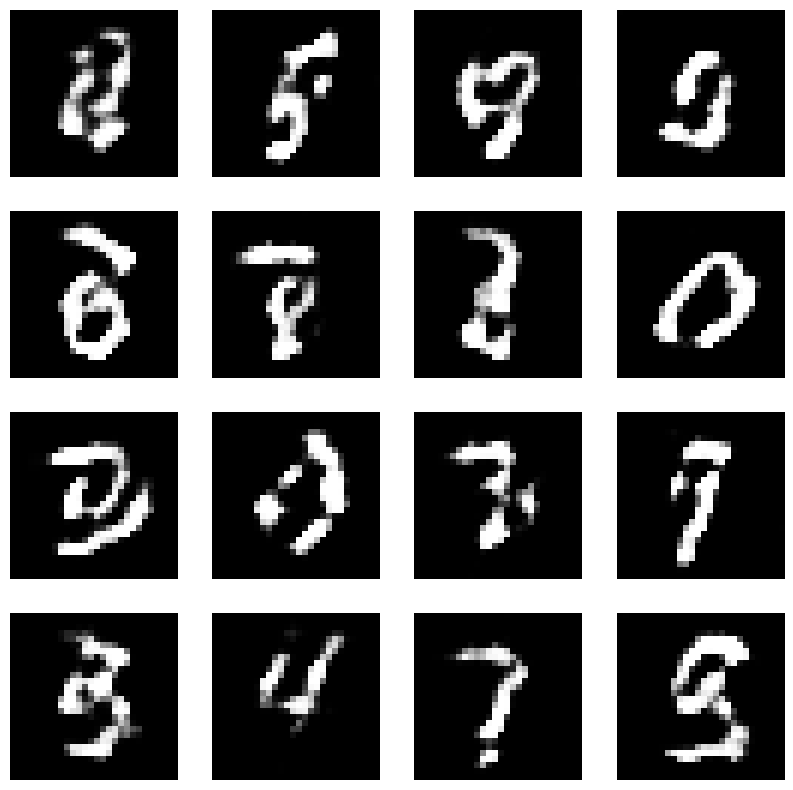

Epoch:  51


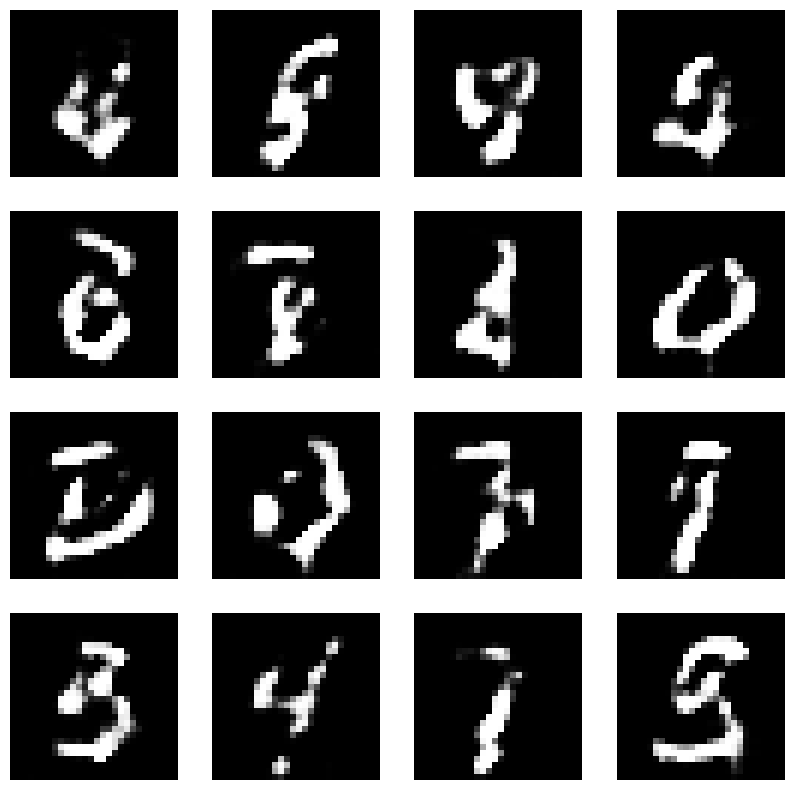

Epoch:  52


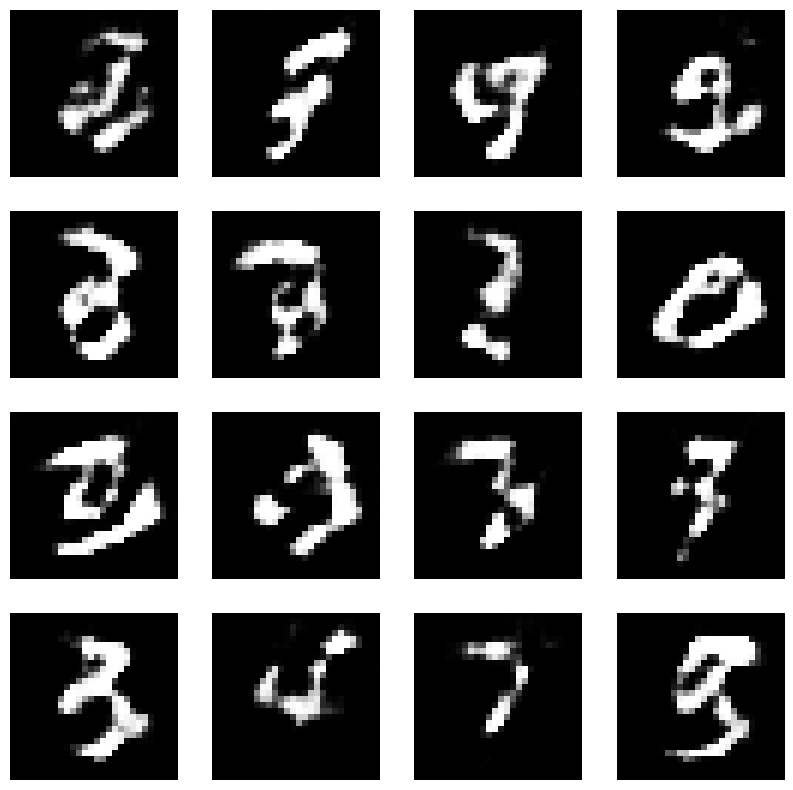

Epoch:  53


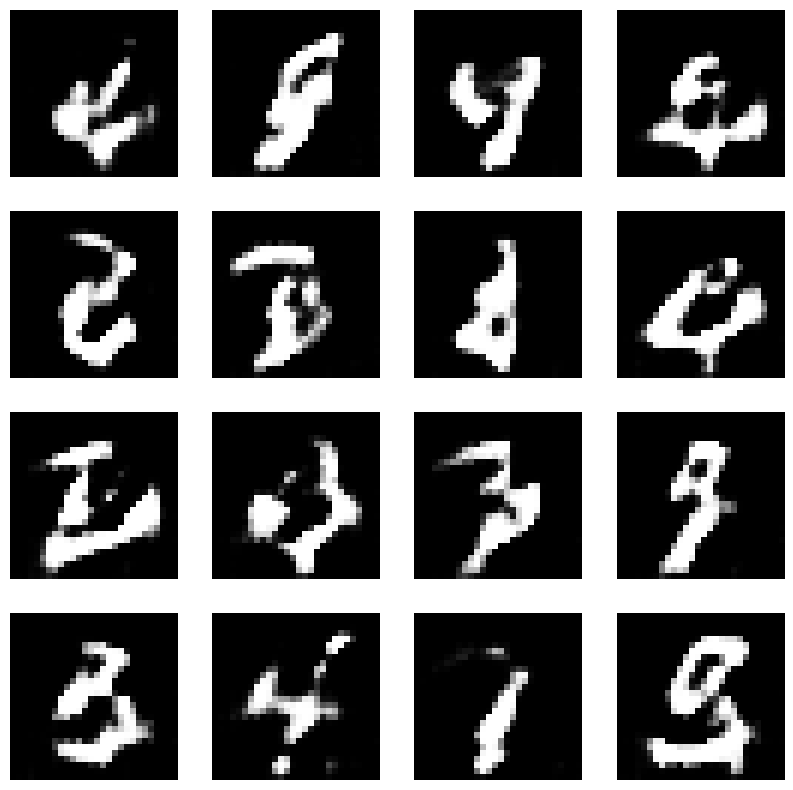

Epoch:  54


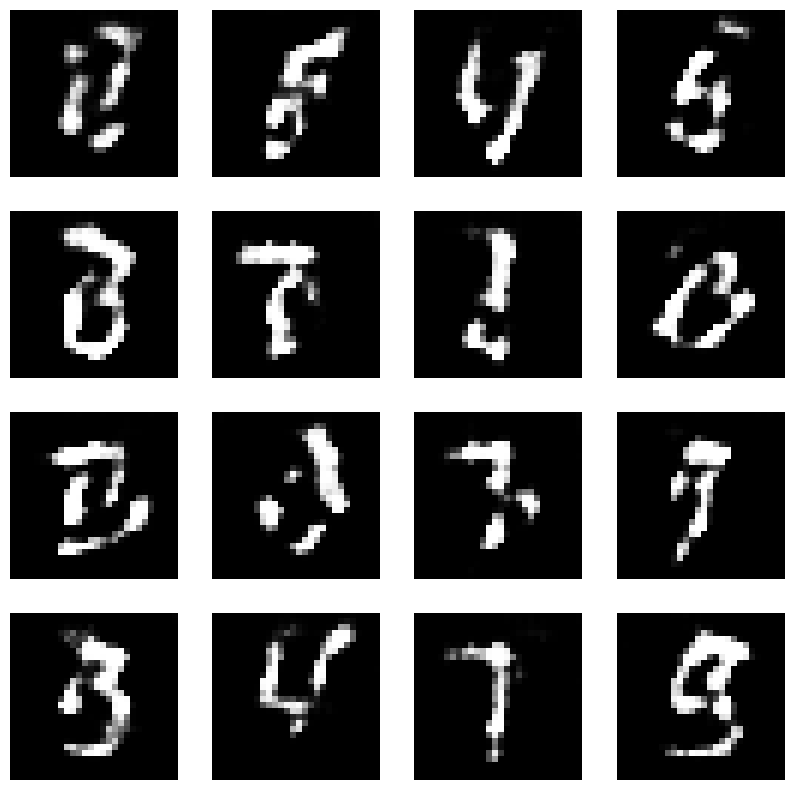

Epoch:  55


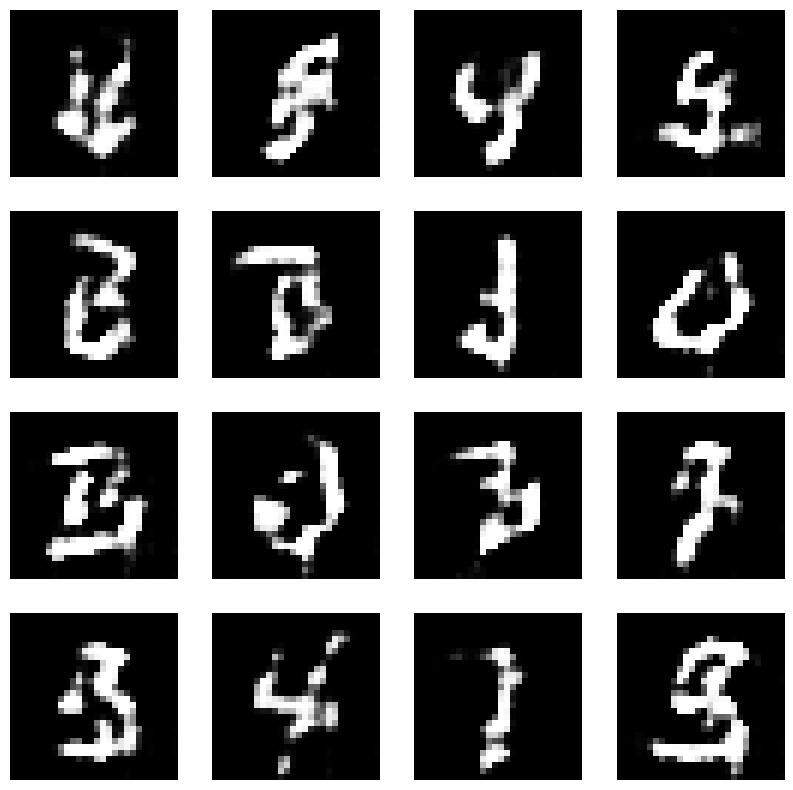

Epoch:  56


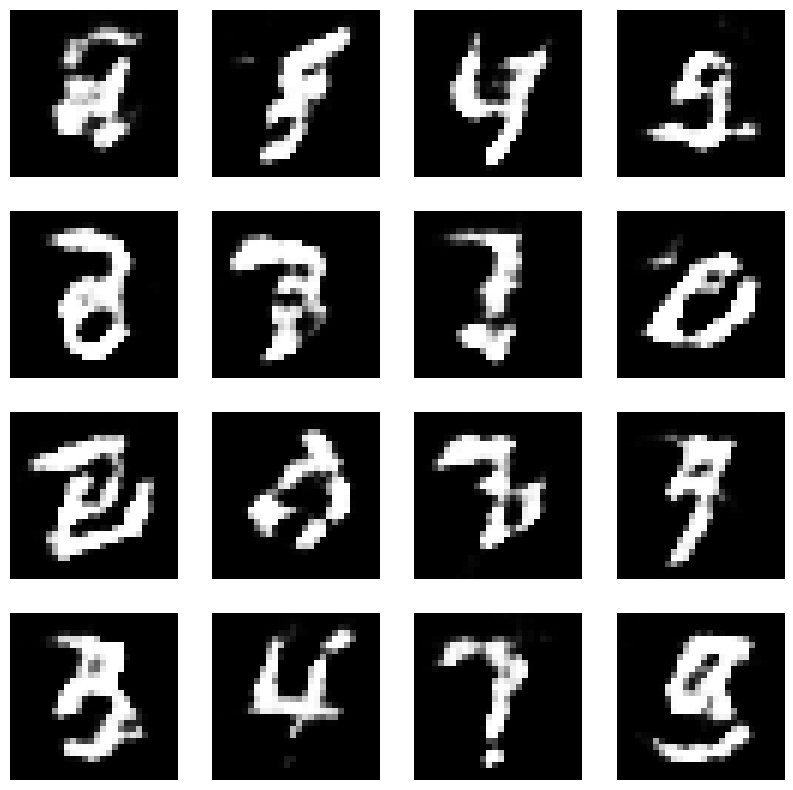

Epoch:  57


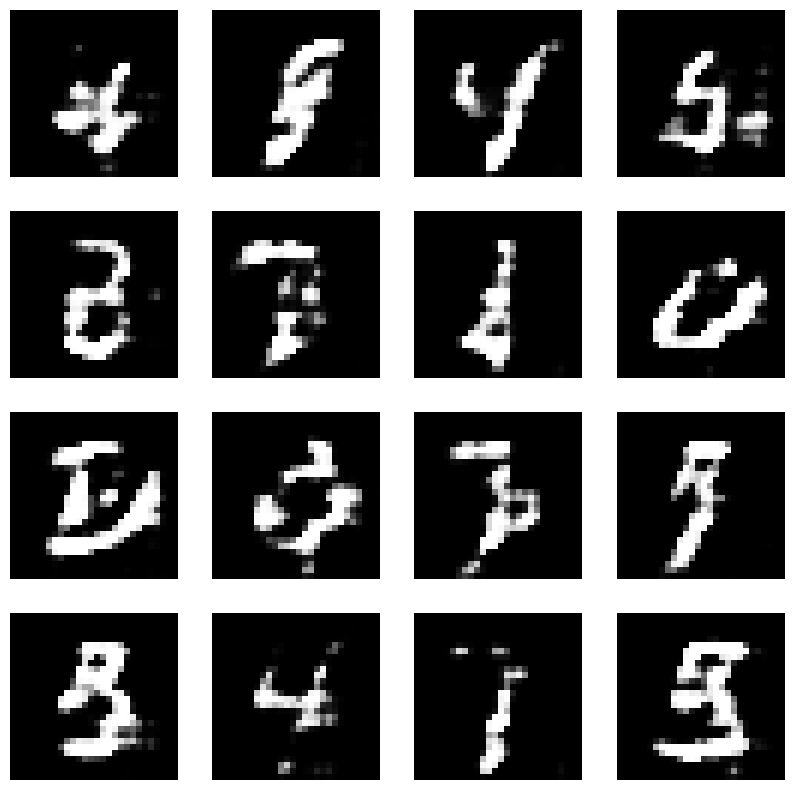

Epoch:  58


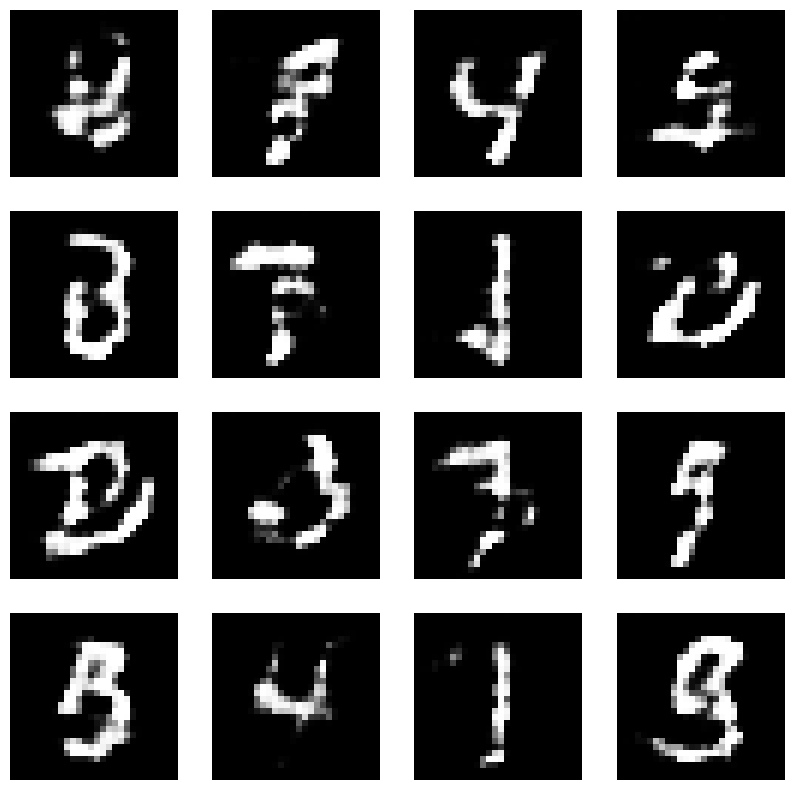

Epoch:  59


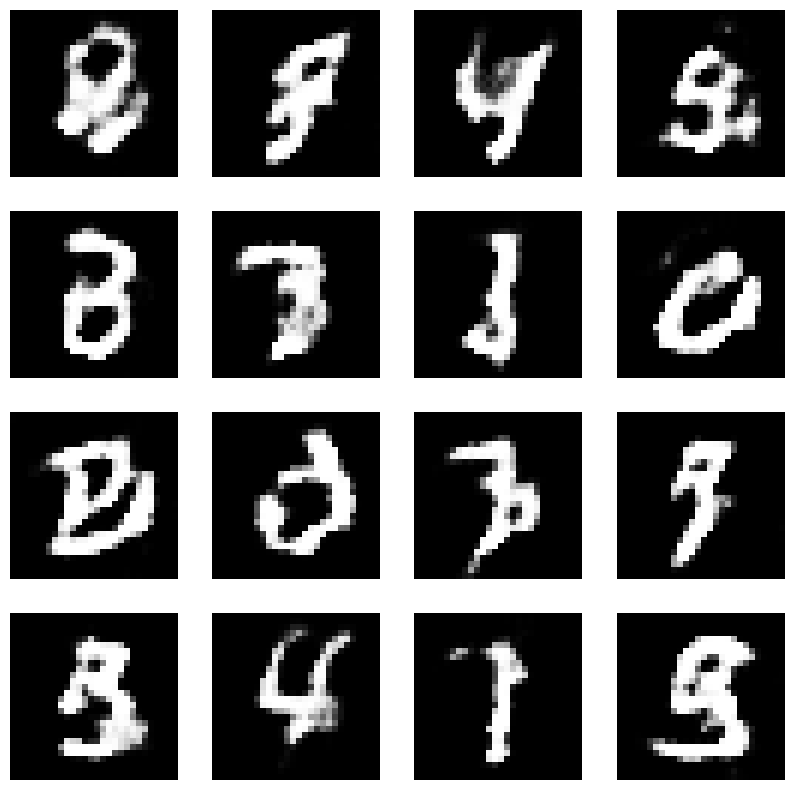

Epoch:  60


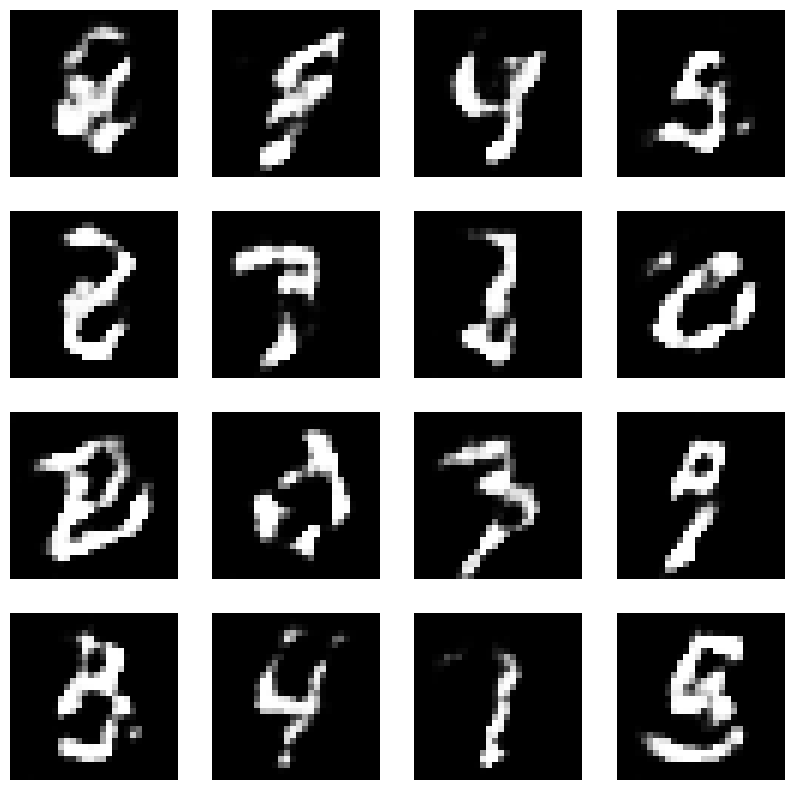

Epoch:  61


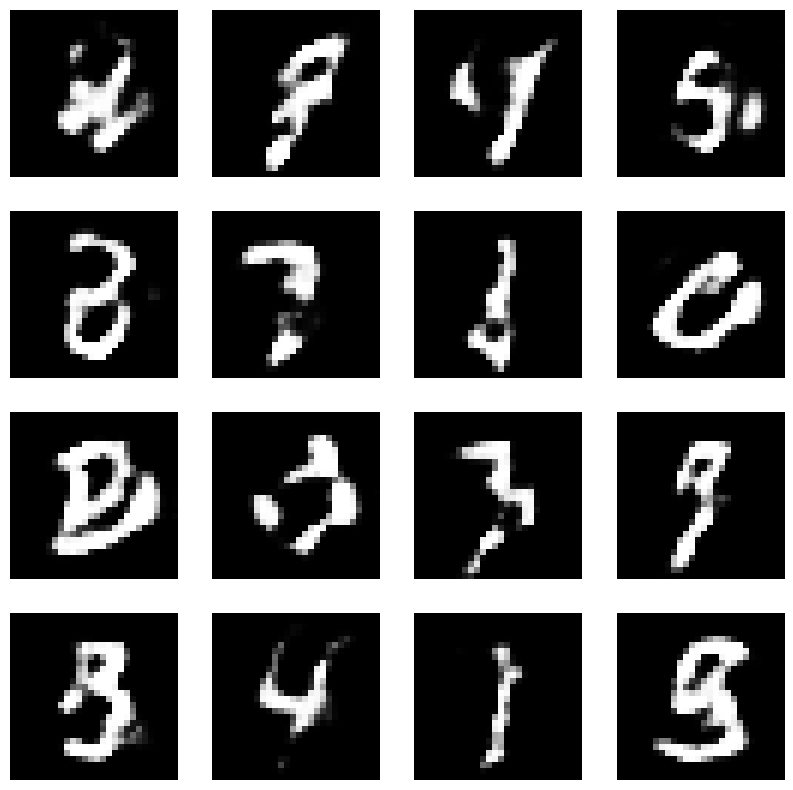

Epoch:  62


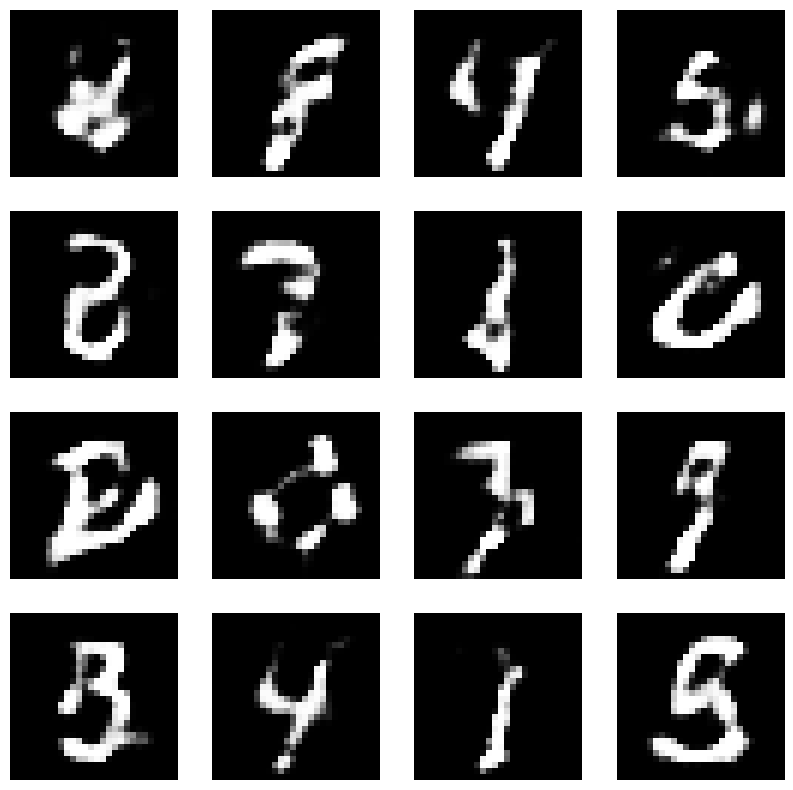

Epoch:  63


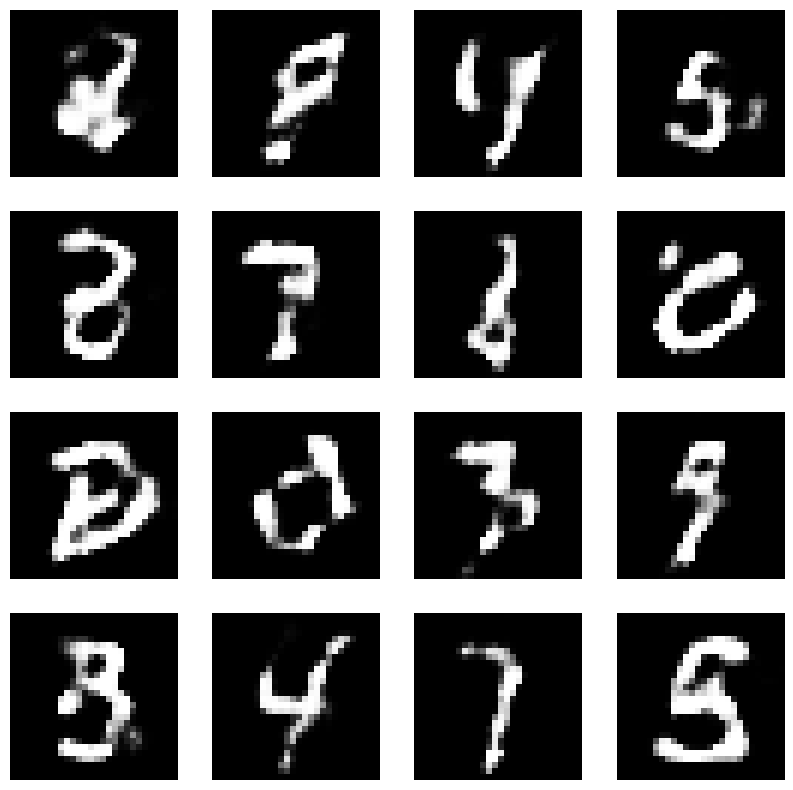

Epoch:  64


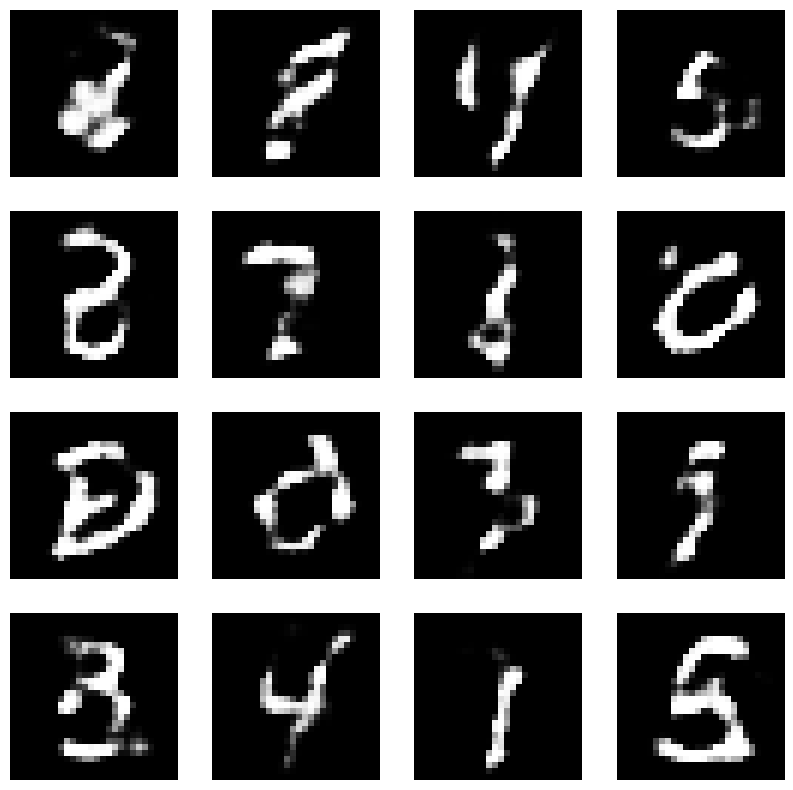

Epoch:  65


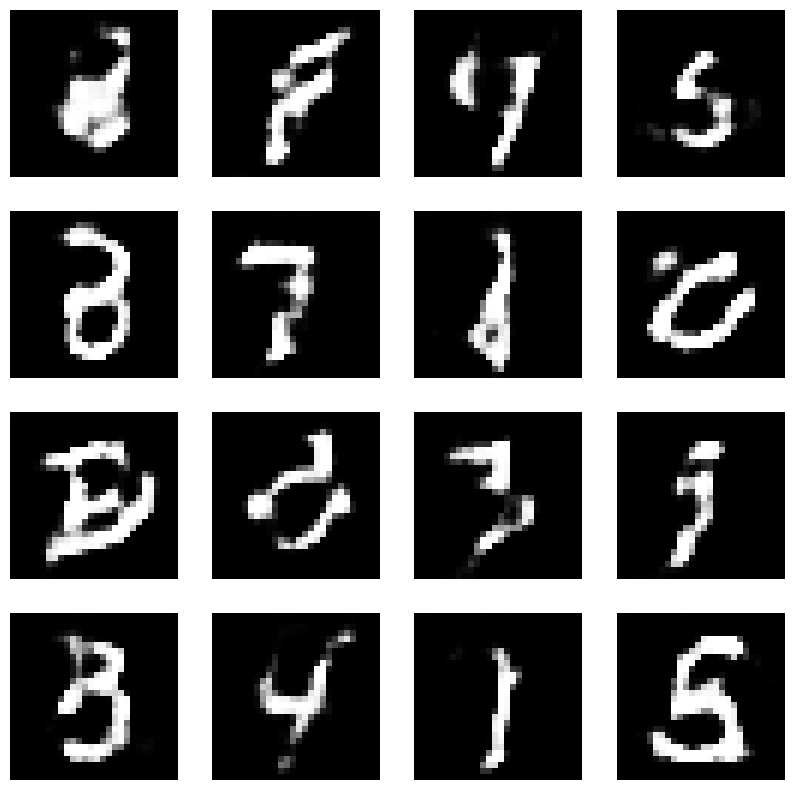

Epoch:  66


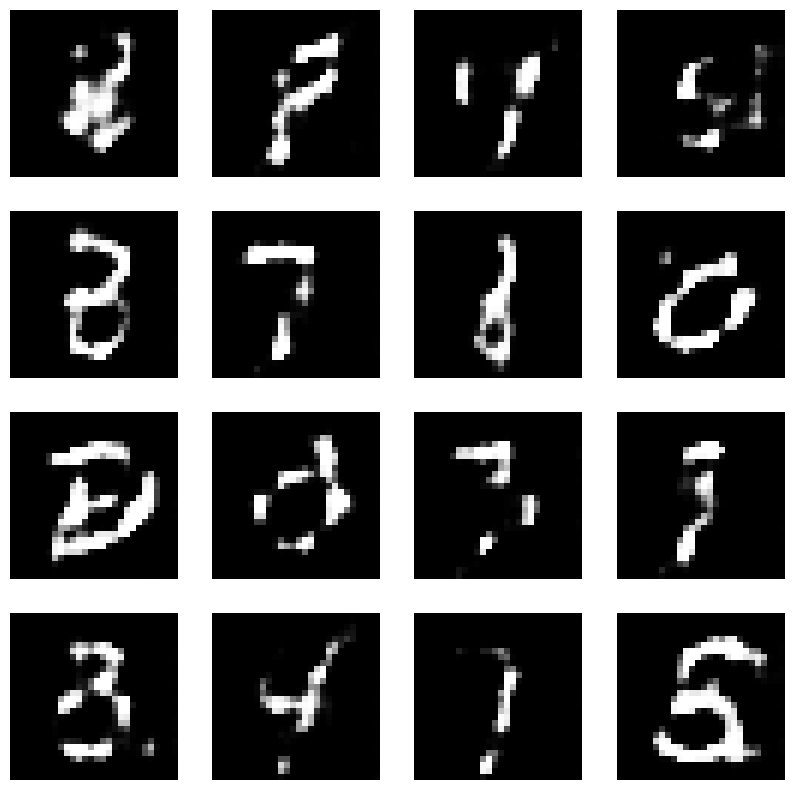

Epoch:  67


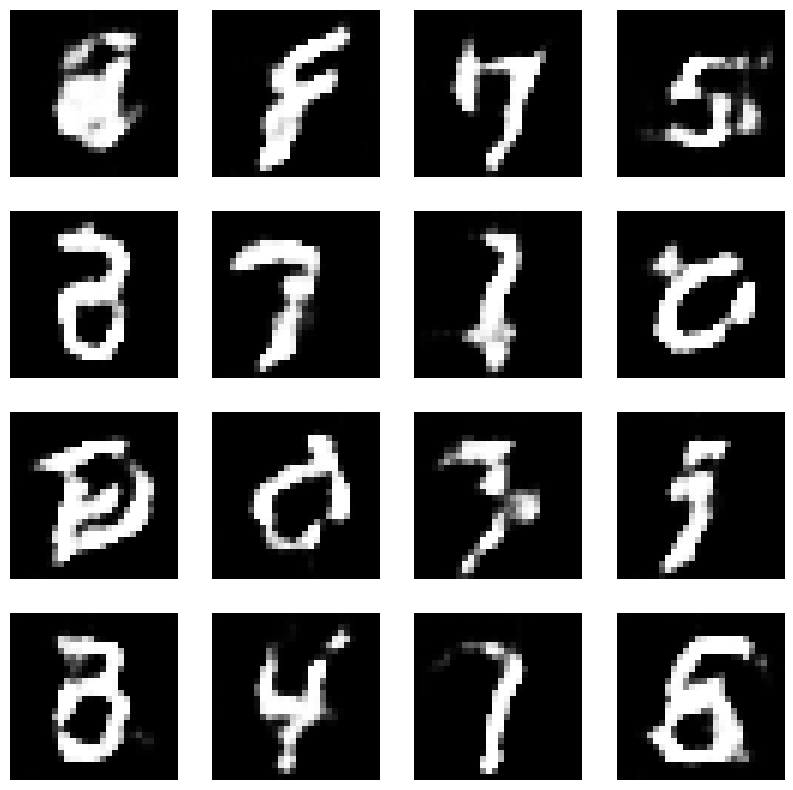

Epoch:  68


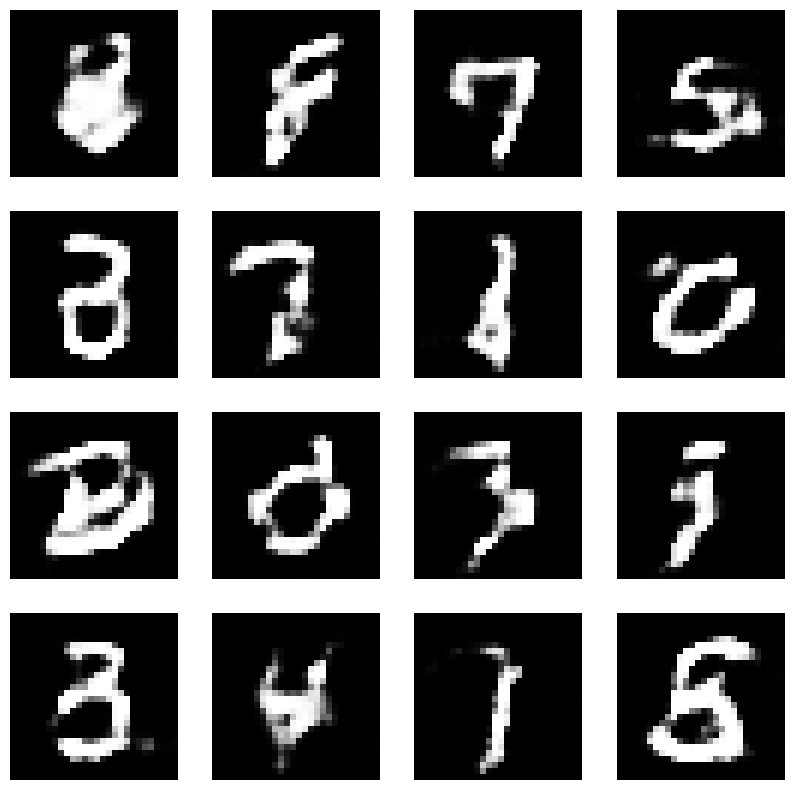

Epoch:  69


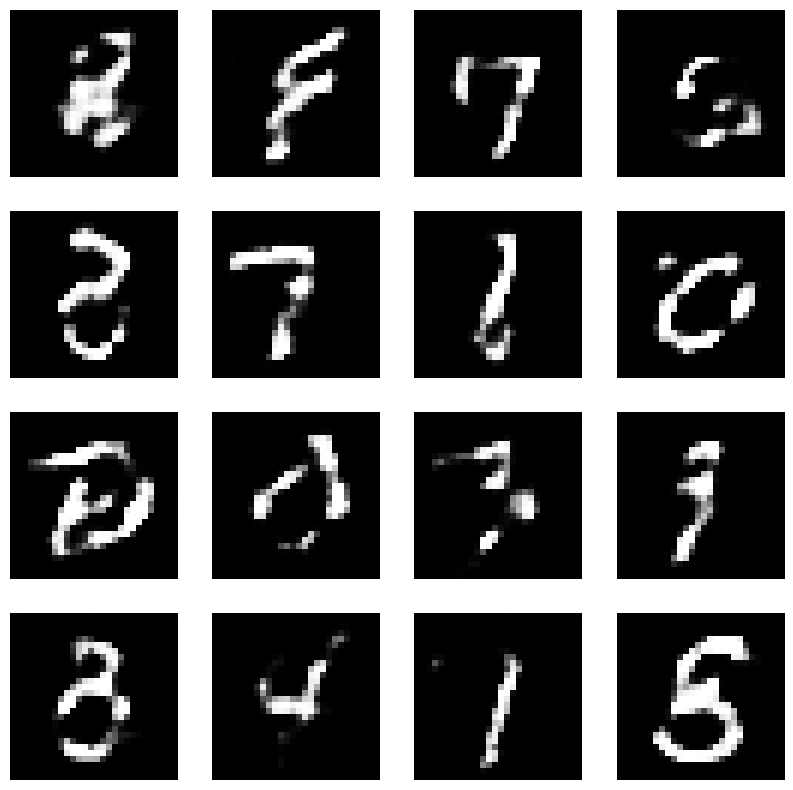

Epoch:  70


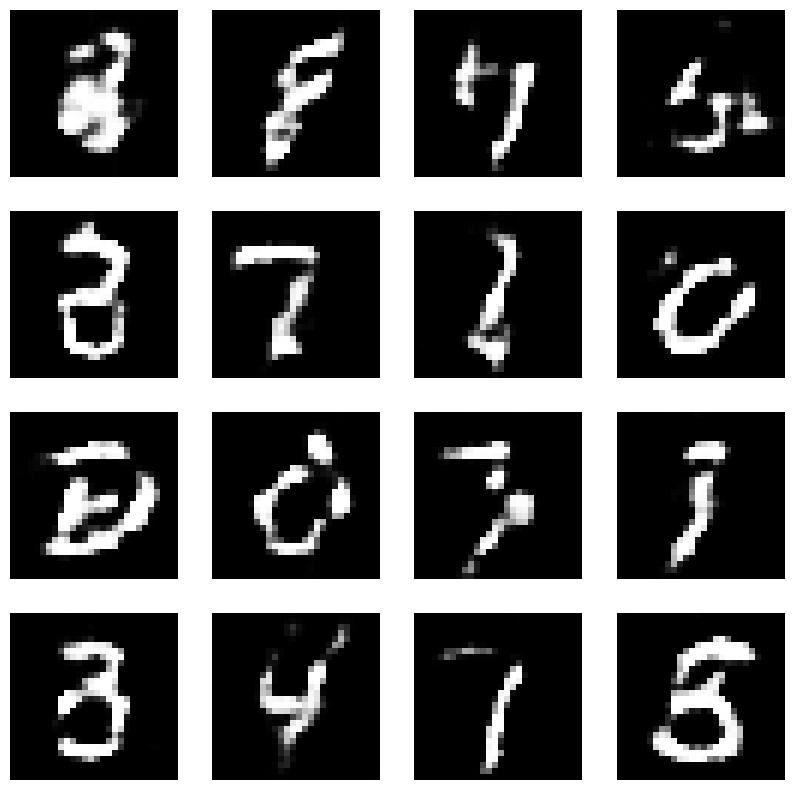

Epoch:  71


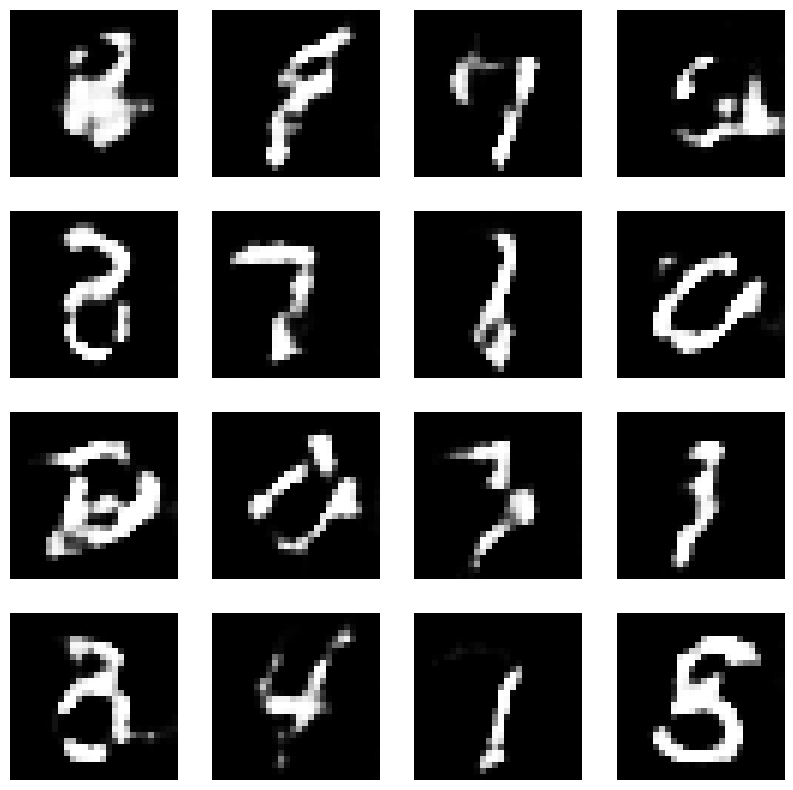

Epoch:  72


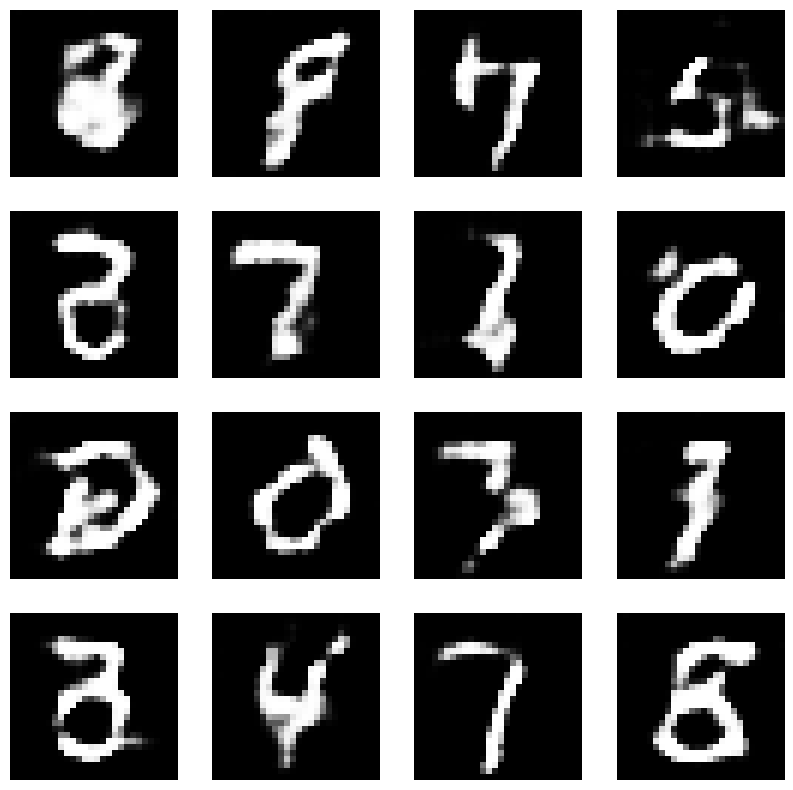

Epoch:  73


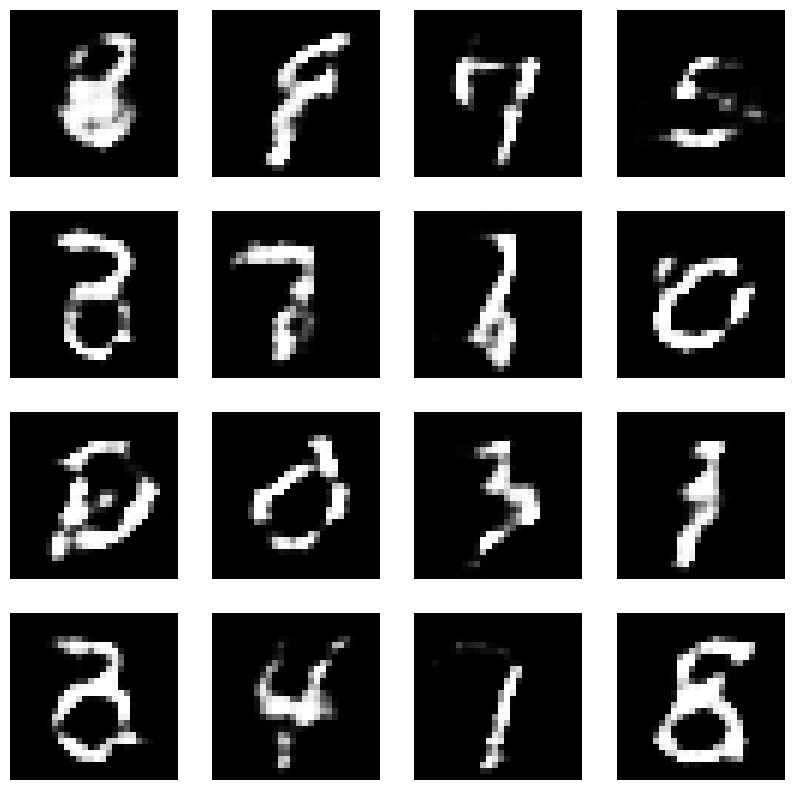

Epoch:  74


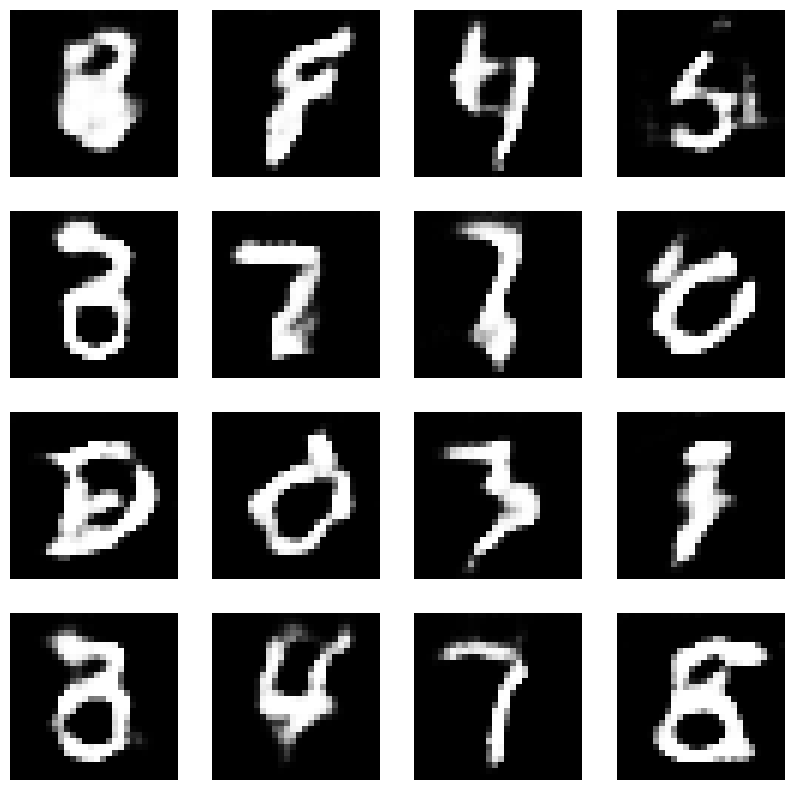

Epoch:  75


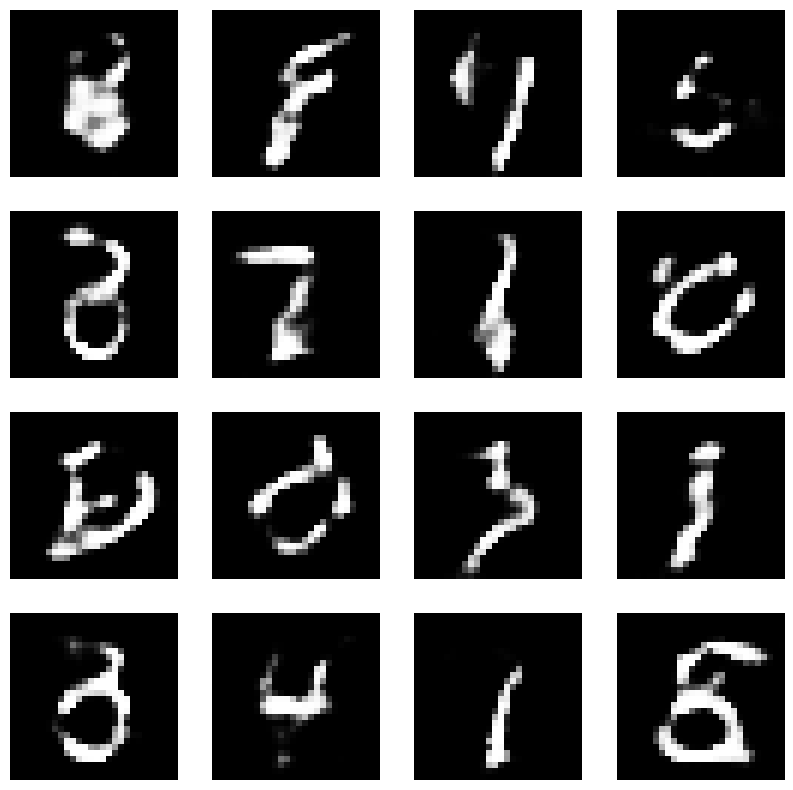

Epoch:  76


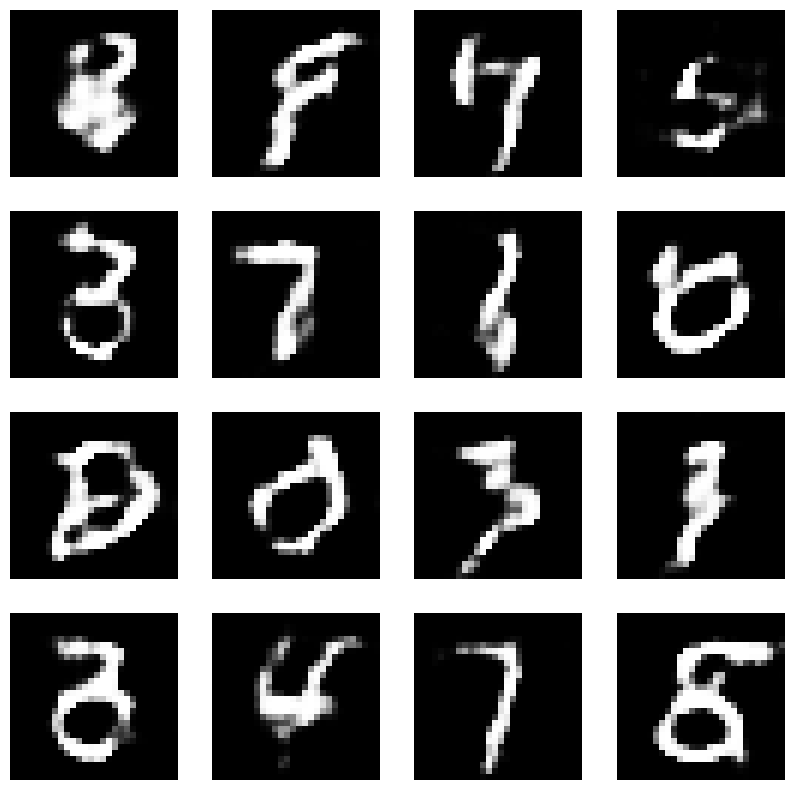

Epoch:  77


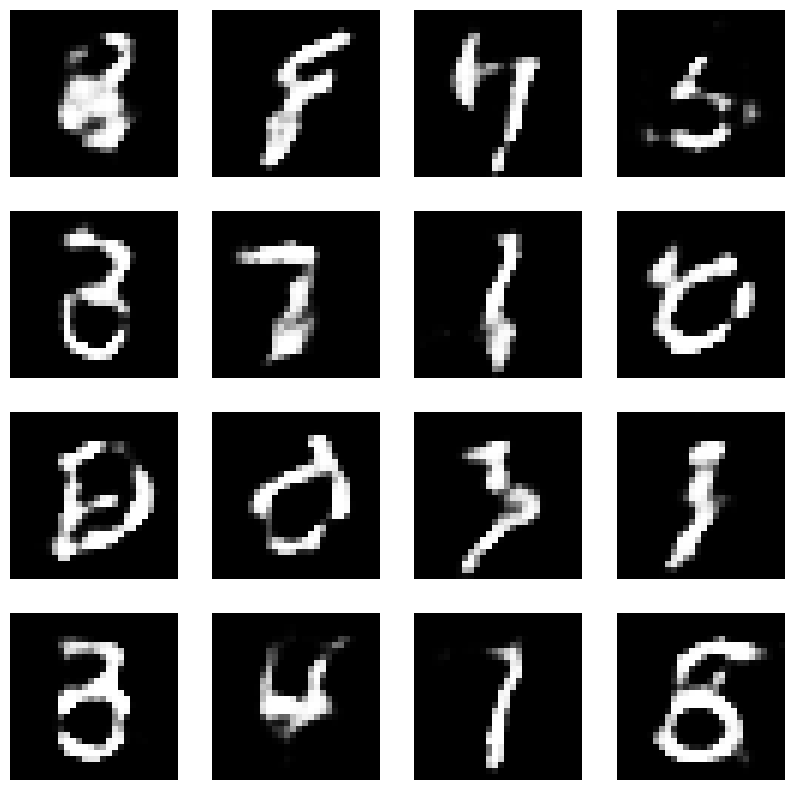

Epoch:  78


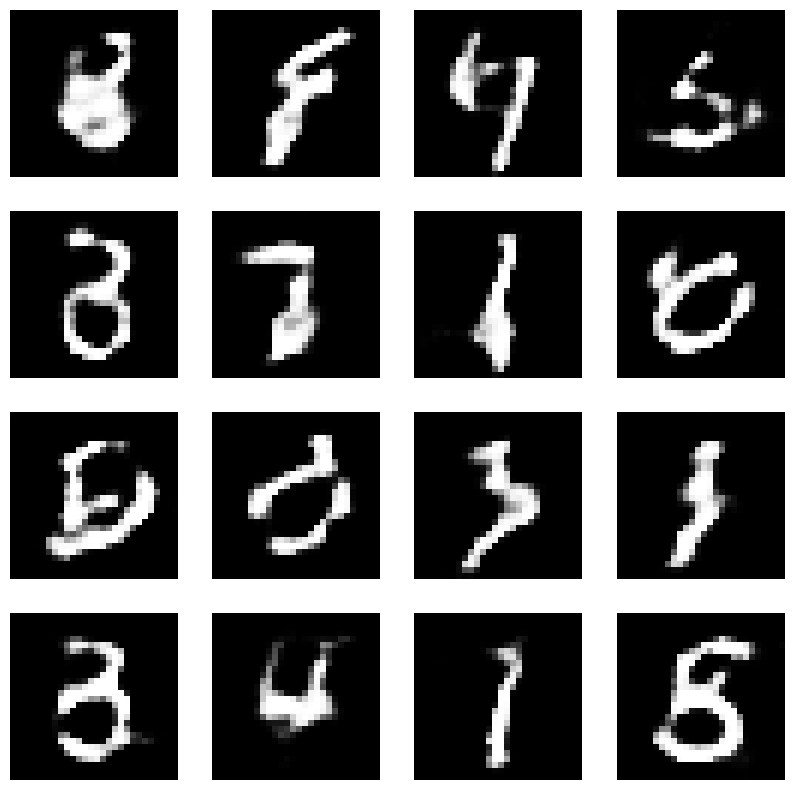

Epoch:  79


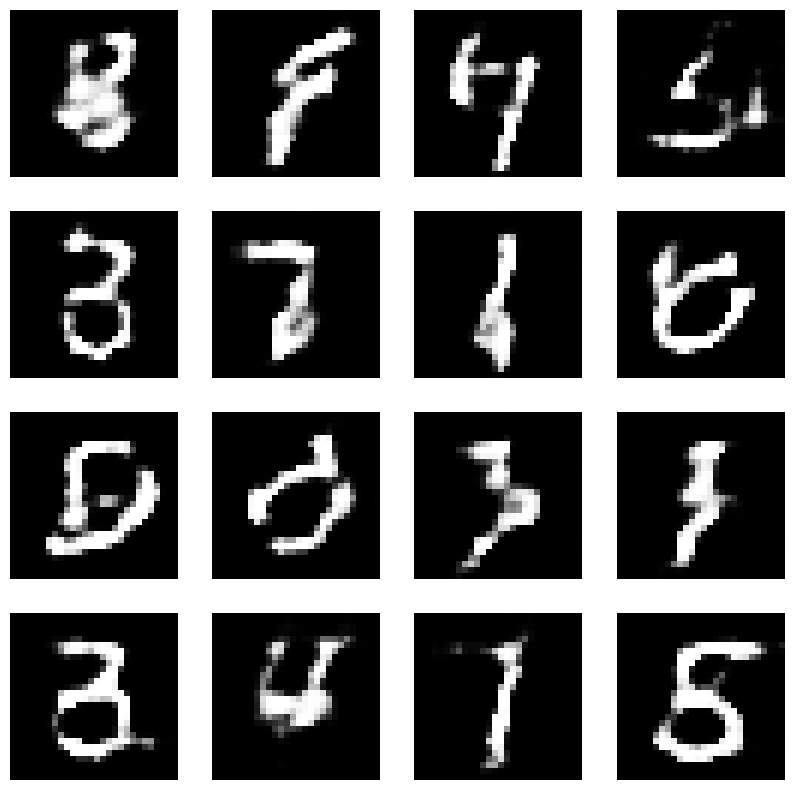

Epoch:  80


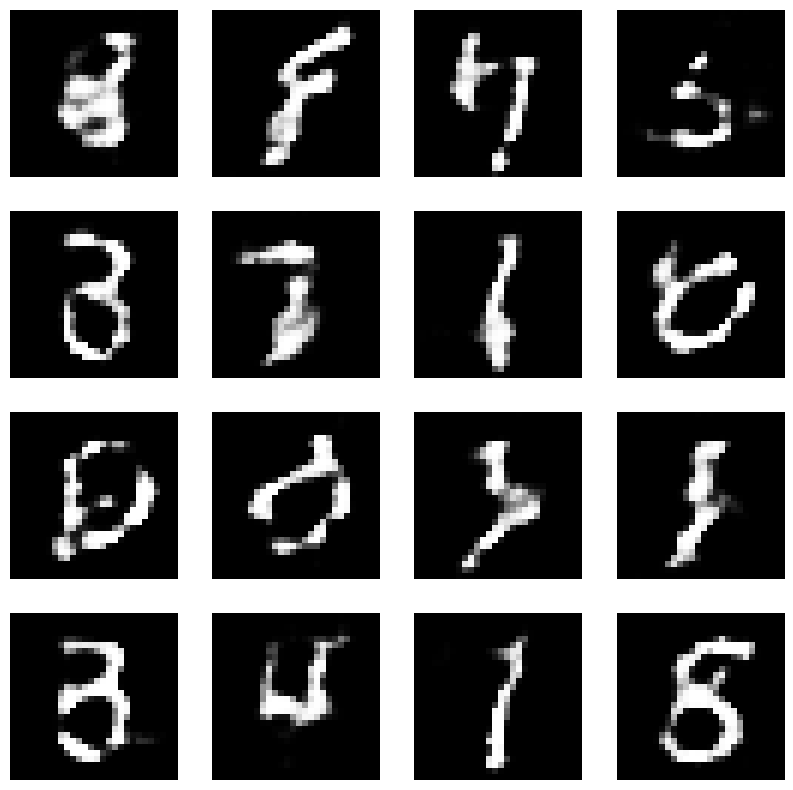

Epoch:  81


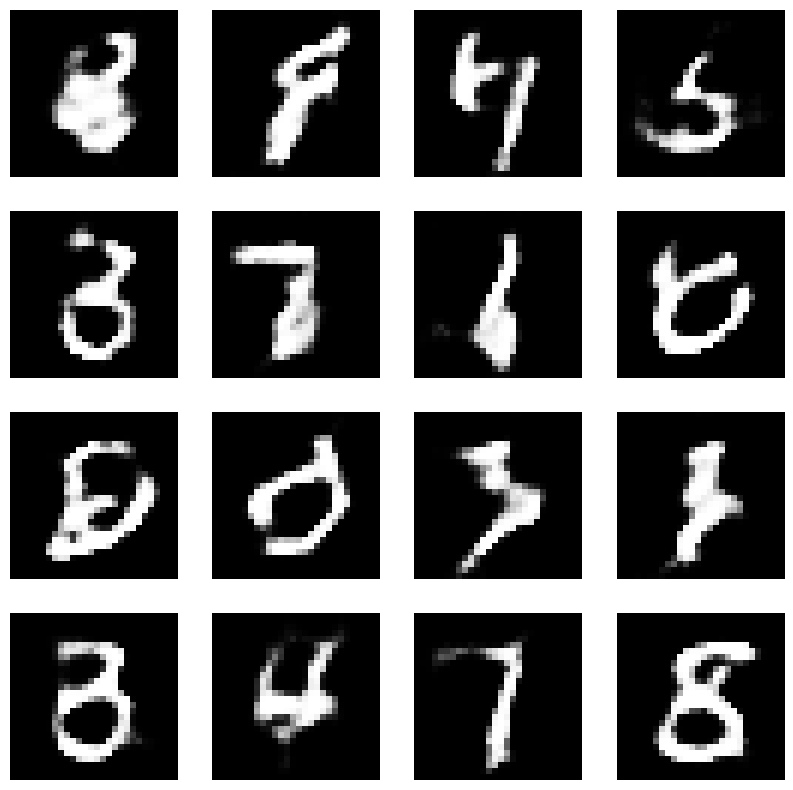

Epoch:  82


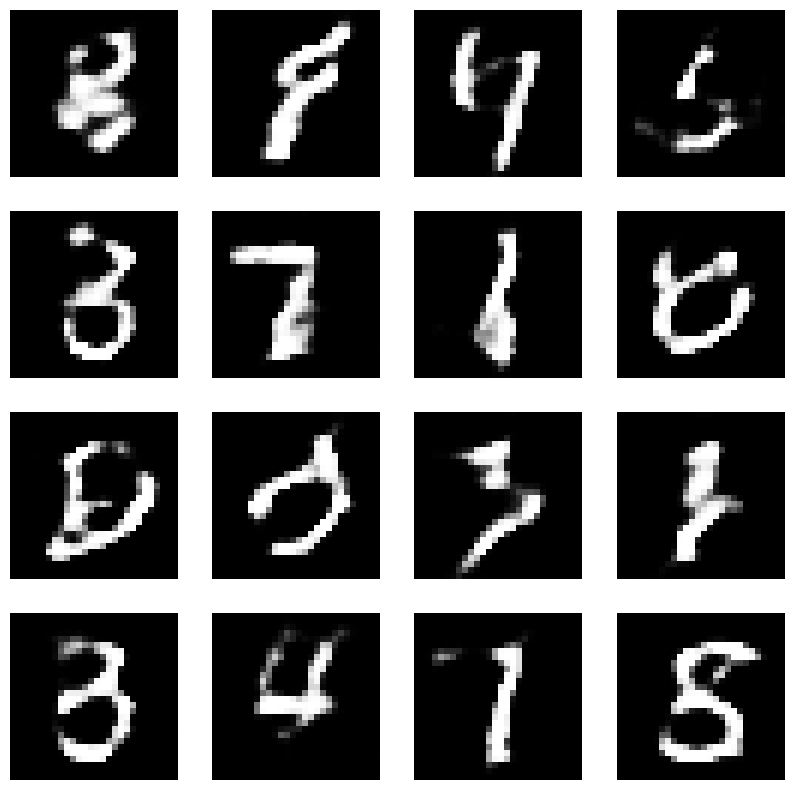

Epoch:  83


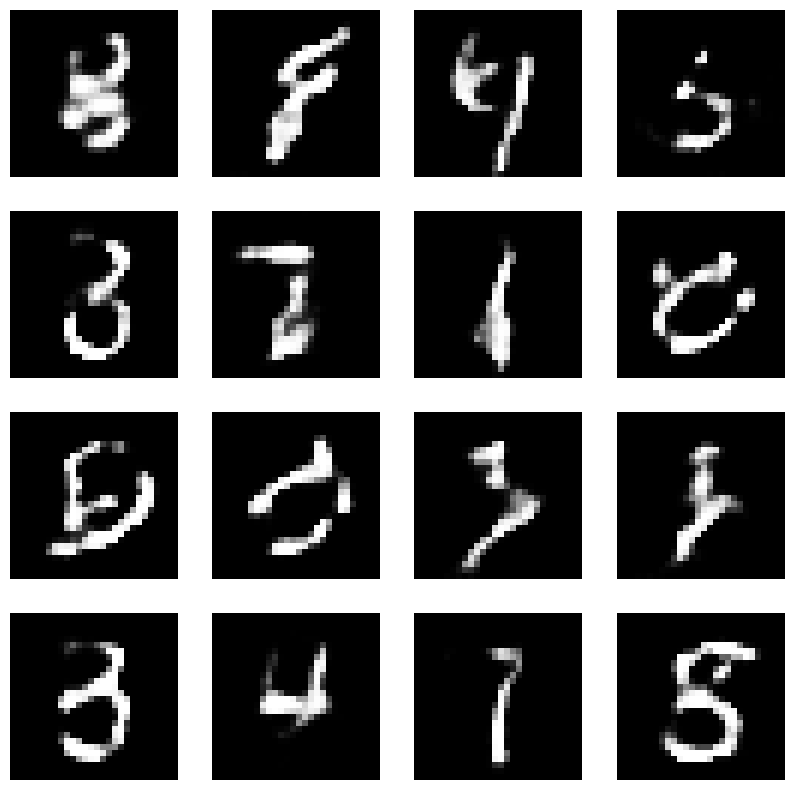

Epoch:  84


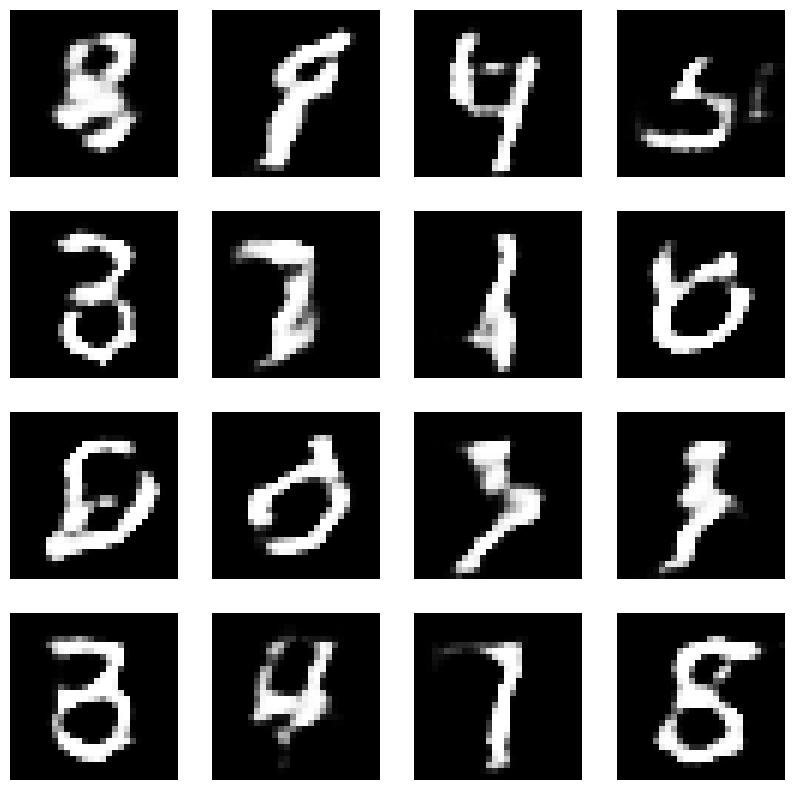

Epoch:  85


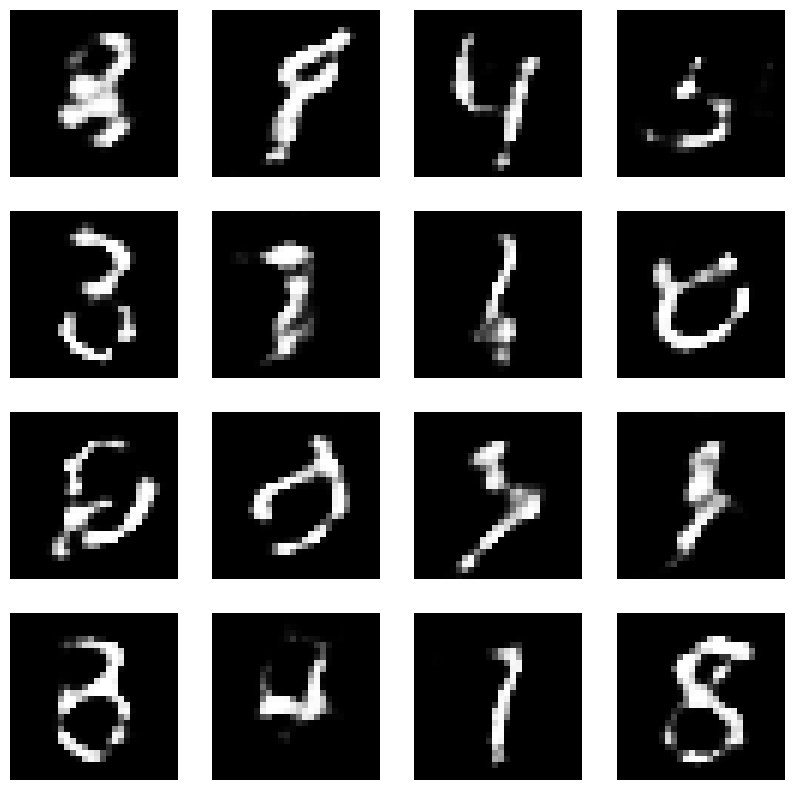

Epoch:  86


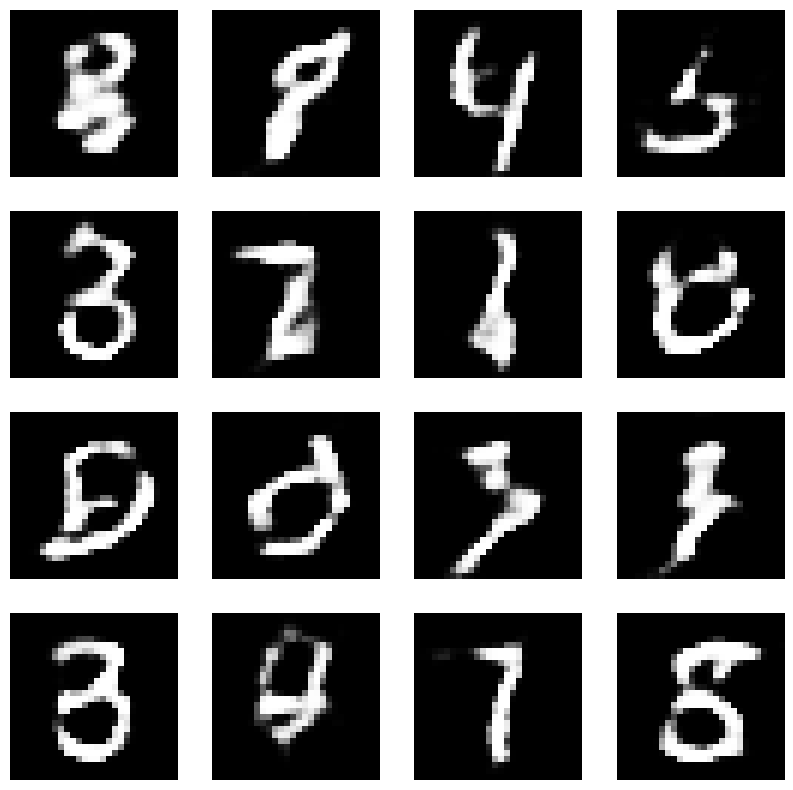

Epoch:  87


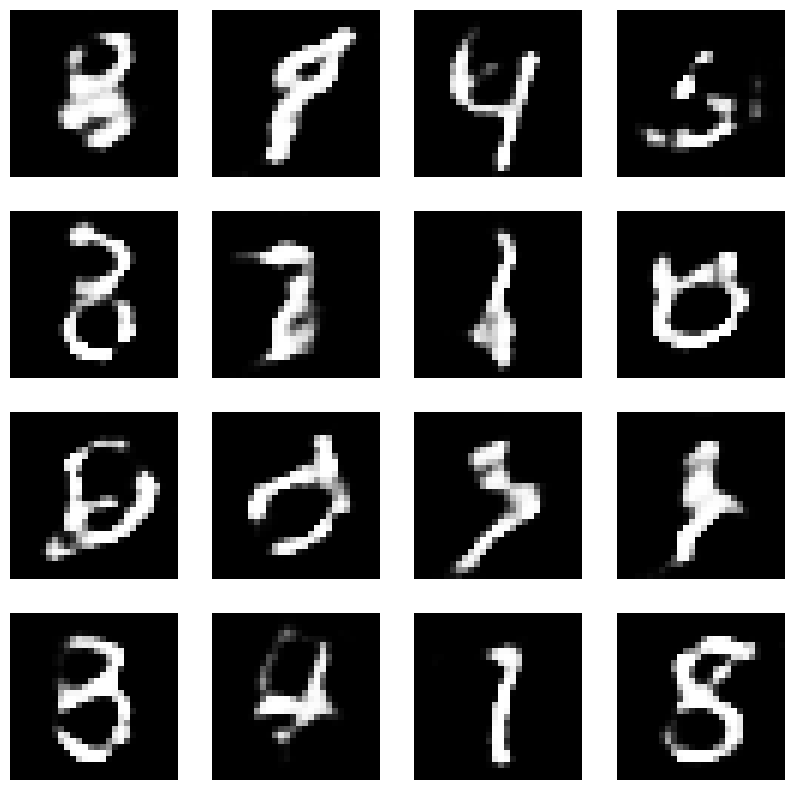

Epoch:  88


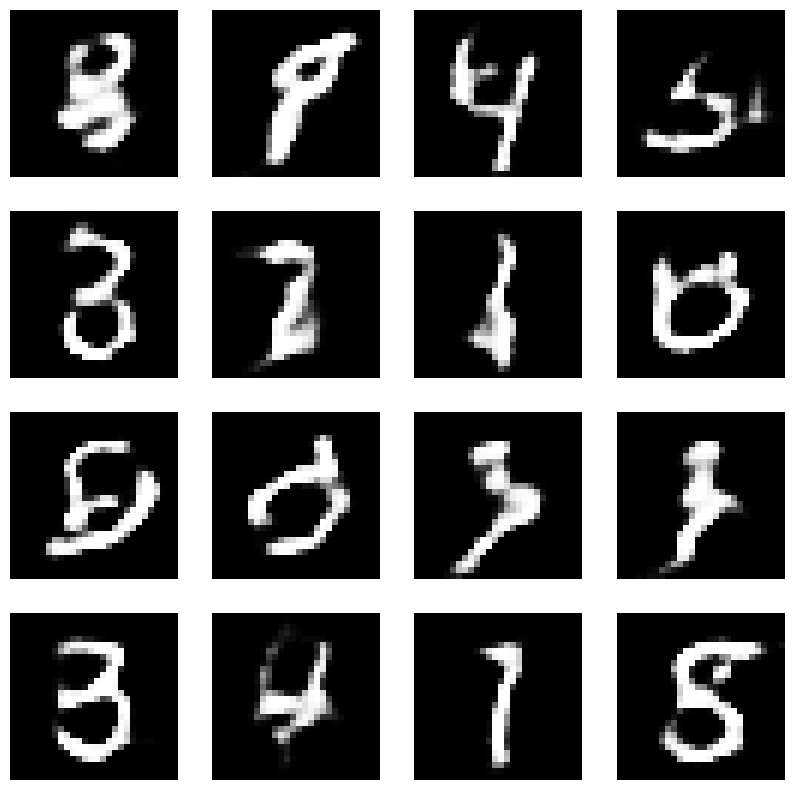

Epoch:  89


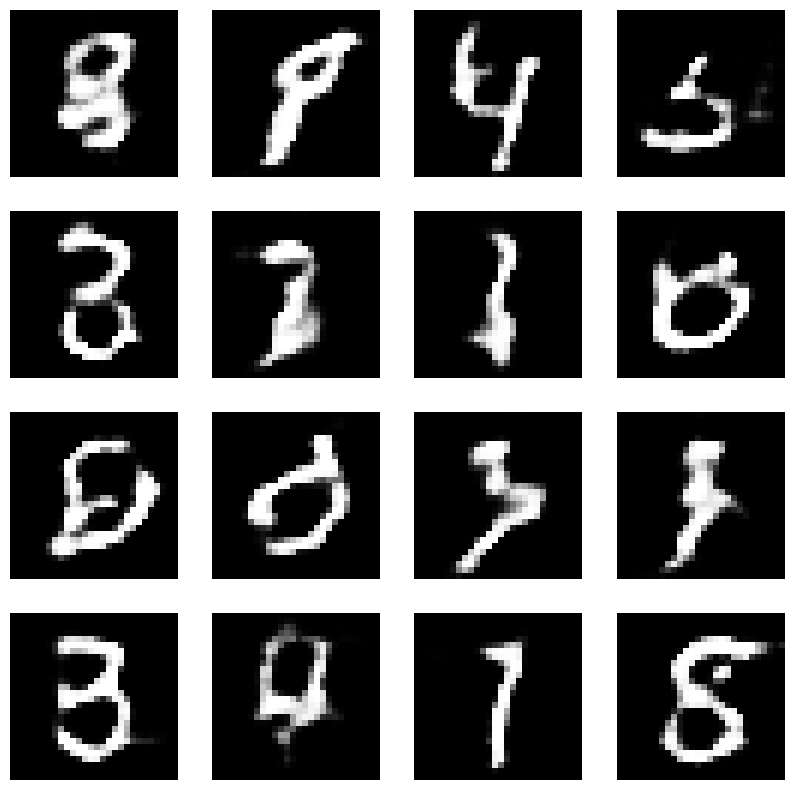

Epoch:  90


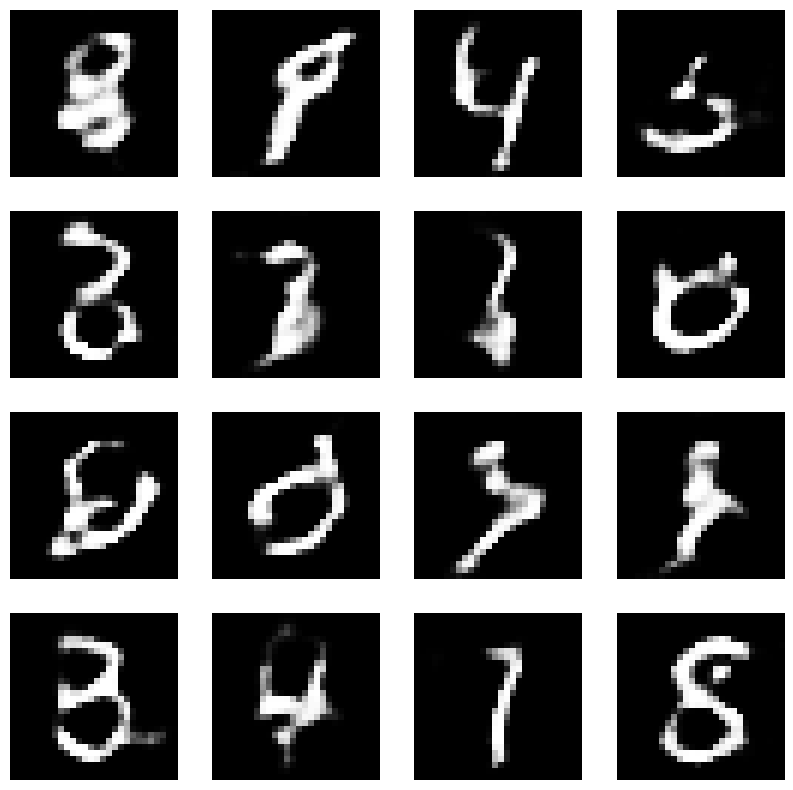

Epoch:  91


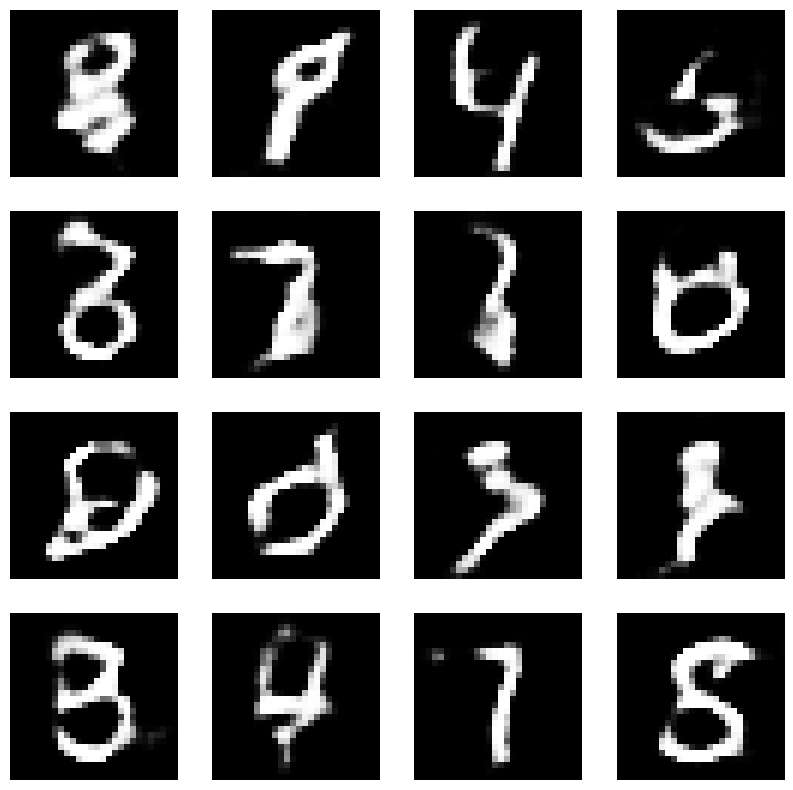

Epoch:  92


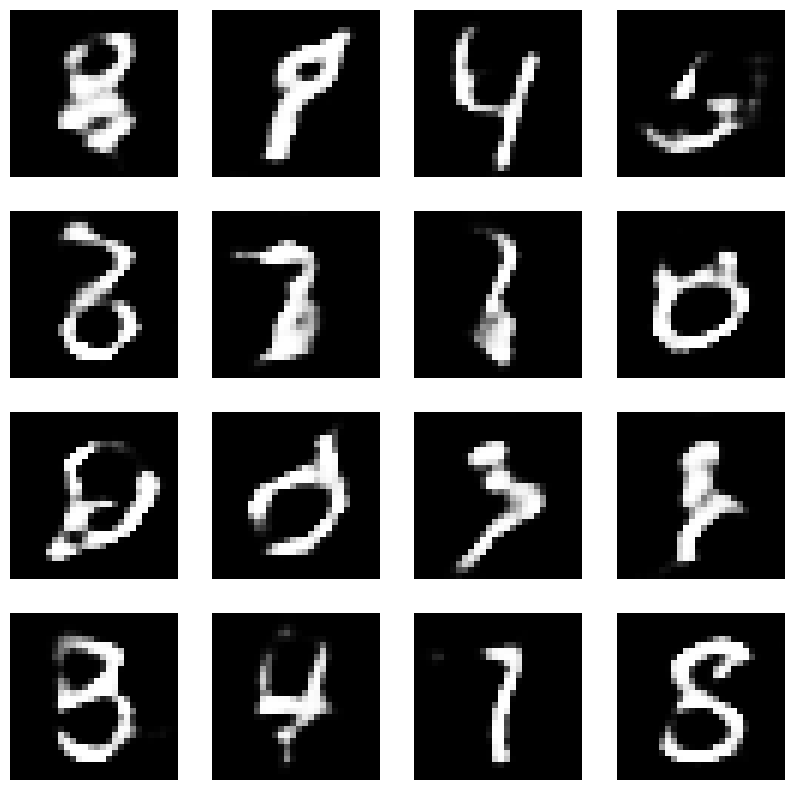

Epoch:  93


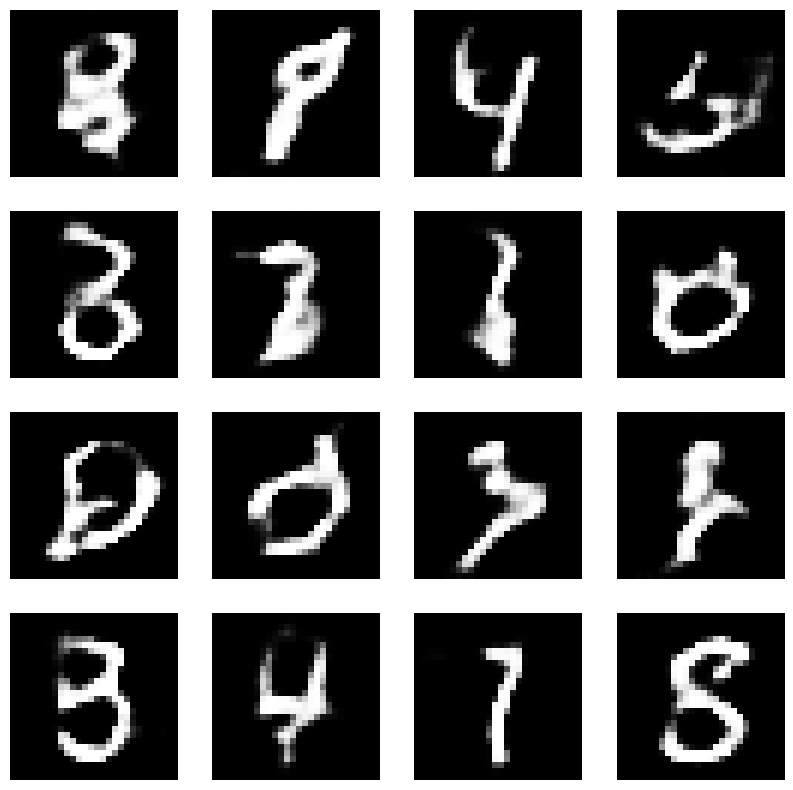

Epoch:  94


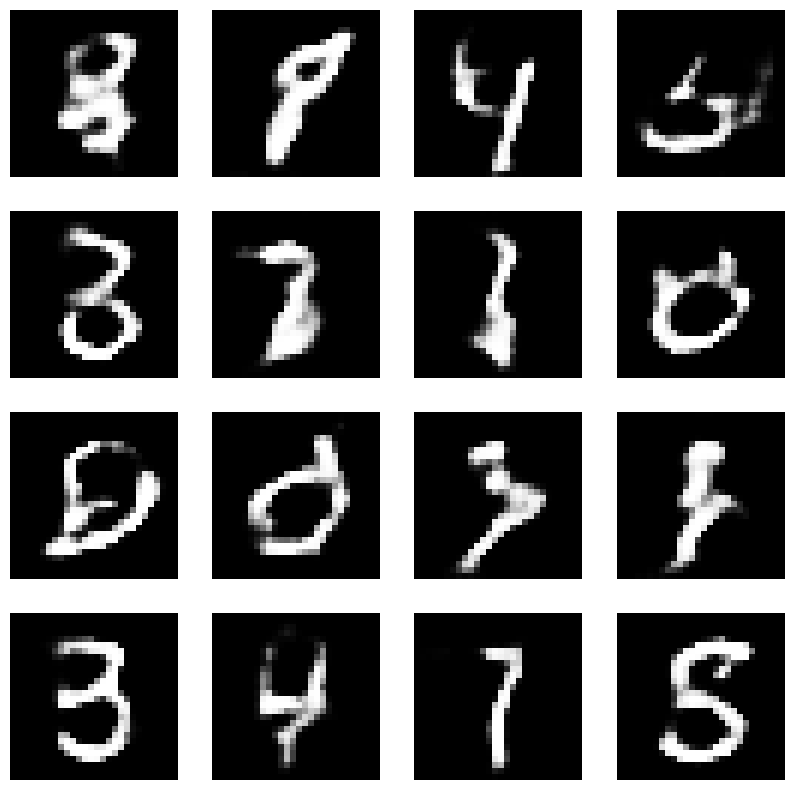

Epoch:  95


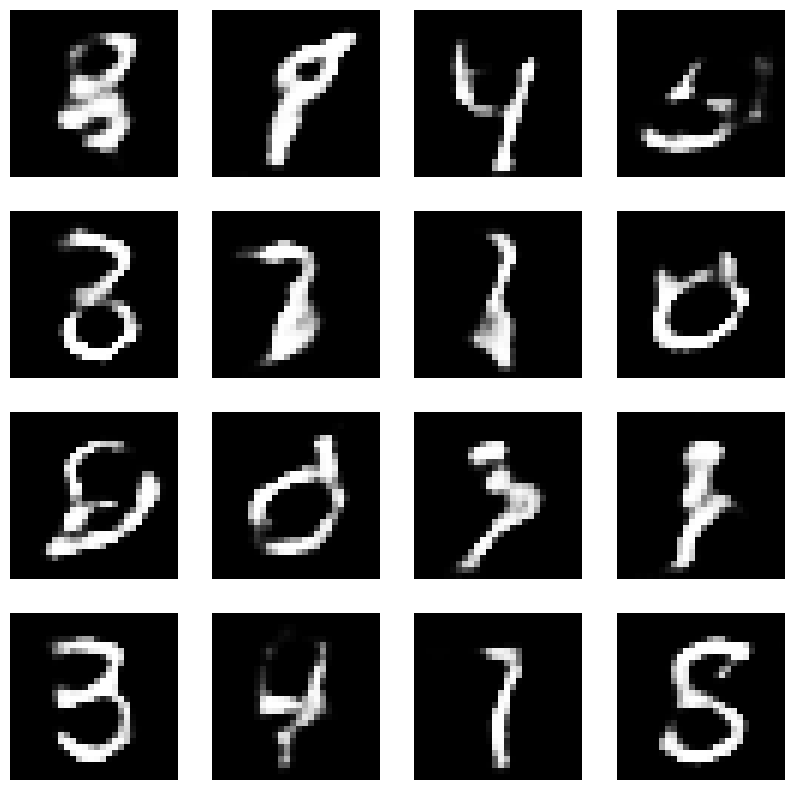

Epoch:  96


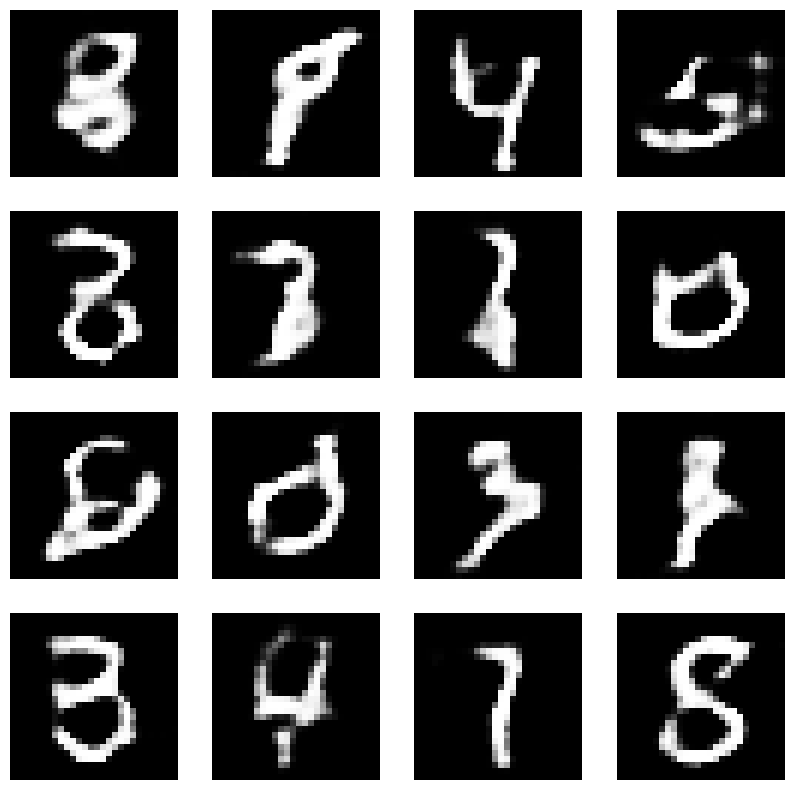

Epoch:  97


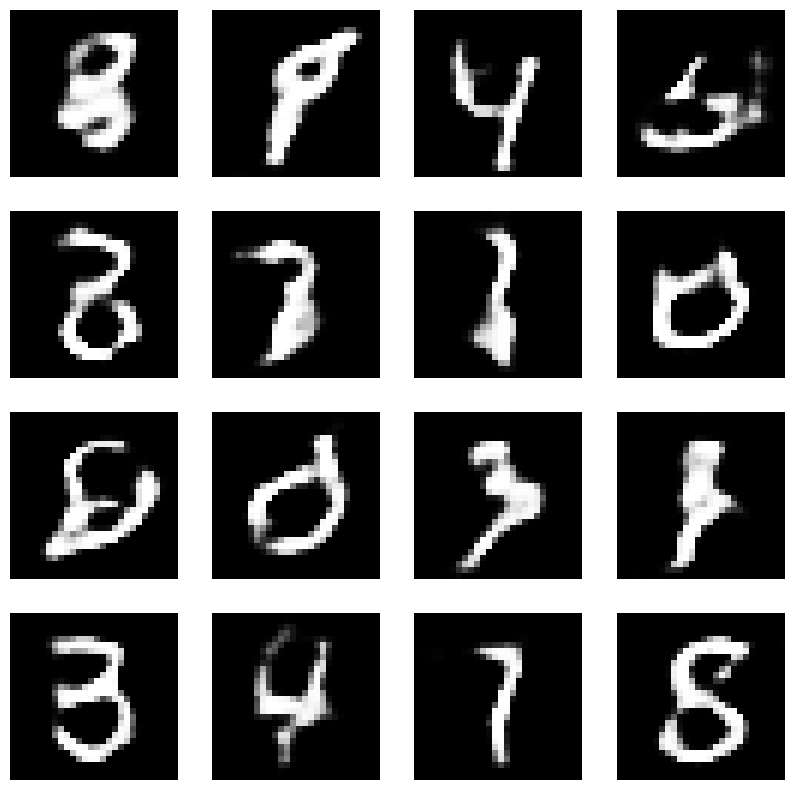

Epoch:  98


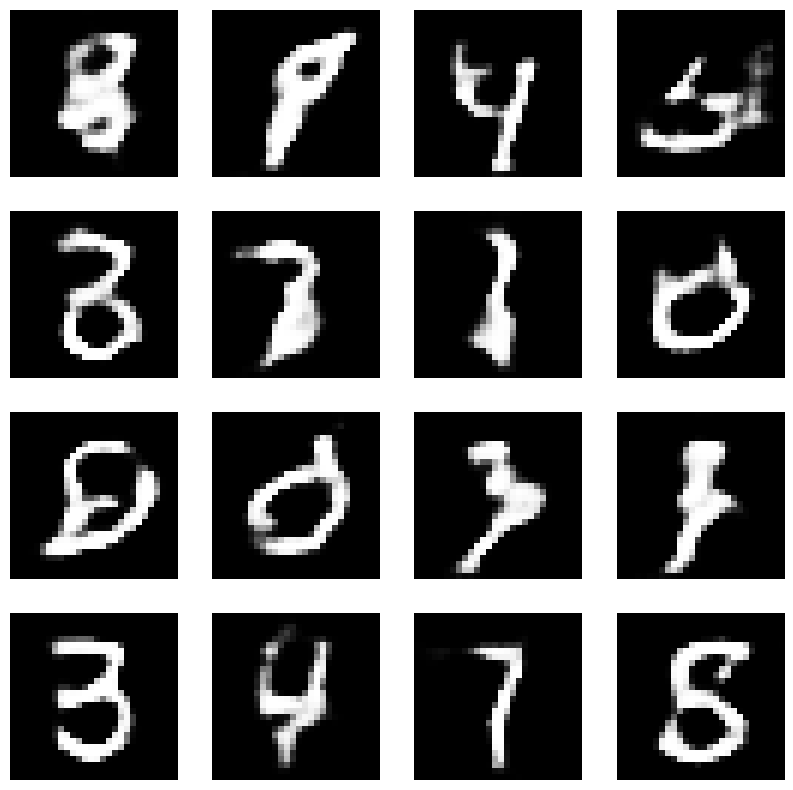

Epoch:  99


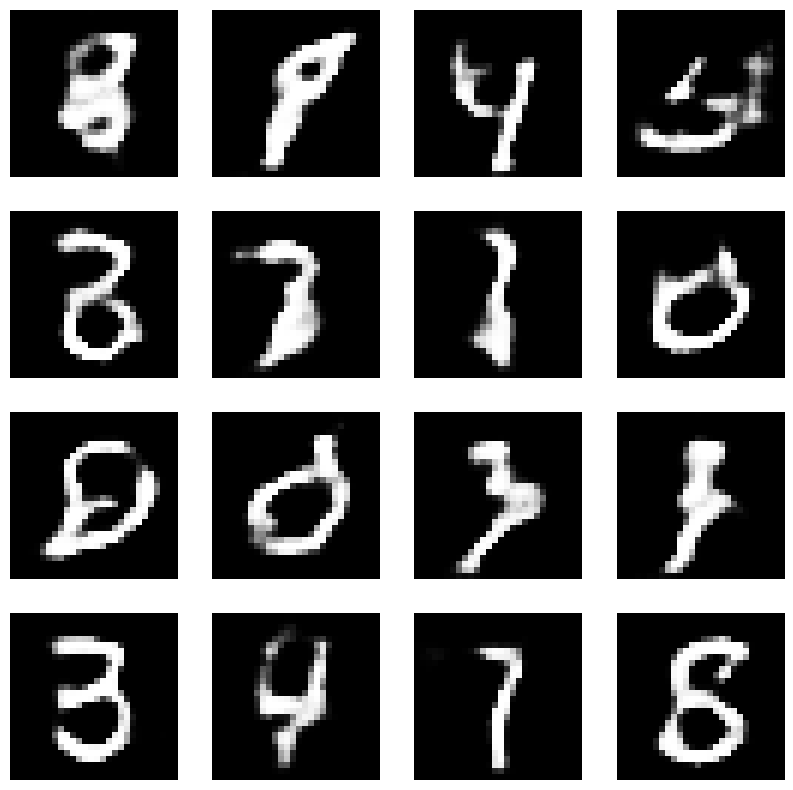

Epoch:  100


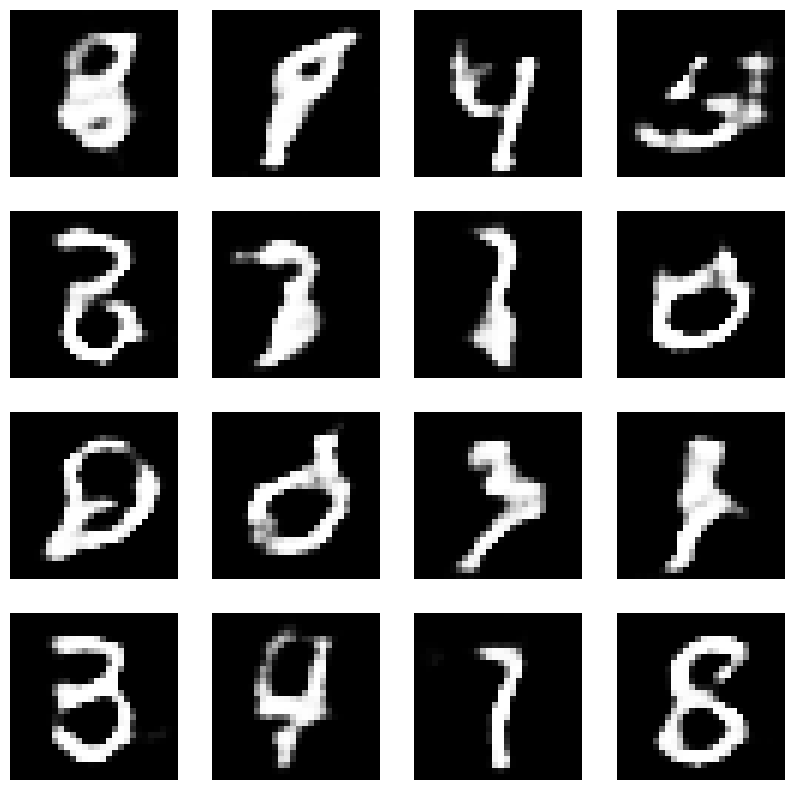

In [48]:
# train_gan(X_train, epochs, test_images)

In [61]:
# generator.save('generator_modelDCGANCOLLAB.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

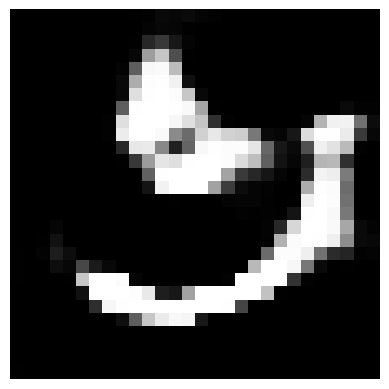

In [125]:
# Recreate the generator model (assuming you have access to the original build_generator function)
generator = build_generator()

# Load weights
generator.load_weights('generator_modelDCGANCOLLAB.keras')

# Now use this generator


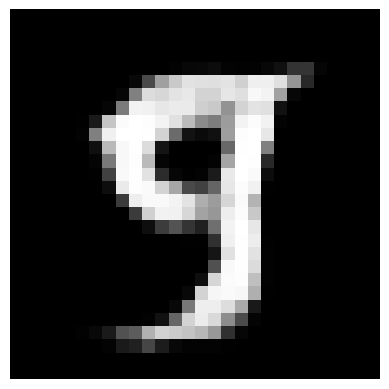

In [151]:
random_noise = tf.random.normal([1, 100])
generated_images = generator(random_noise, training=False)
plt.imshow(generated_images[0, :,:,0], cmap='gray')
plt.axis('off')
plt.show()